## Import Libraries & Set Configurations

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.font_manager as font_manager
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
import locale

from os import getcwd, chdir, listdir
from datetime import timedelta
from datetime import datetime
from random import randint
from random import shuffle, sample


from matplotlib.font_manager import FontProperties, findfont
from matplotlib.patches import Patch
from plotly.subplots import make_subplots
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from peakutils import indexes
from sklearn.preprocessing import MinMaxScaler
from locale import setlocale
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu
from scipy.stats import percentileofscore
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Set the option to display decimals rounded to 2 numbers
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the option to display 274 max rows
pd.set_option('display.max_rows', 100)

# Set the option to display a max of 20 cols
pd.set_option('display.max.columns', 20)


## Utility Functions & Plot Calibration

In [2]:
# function to keep track of df objects in memory

def dfs():
    dataframes = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]
    print(dataframes)

In [ ]:
# Helper function to list available colormaps
def cmaps():
    # List available colormaps
    colormaps = plt.colormaps()

    # Print the list of colormaps
    for cmap in colormaps:
        print(cmap)

In [3]:
# Function to list individual colors available in MpL
def list_mpl_colors():
    # List of named colors available in Matplotlib
    named_colors = mcolors.CSS4_COLORS
    # Print the named colors
    for color_name, color_code in named_colors.items():
        print(f"{color_name}: {color_code}")

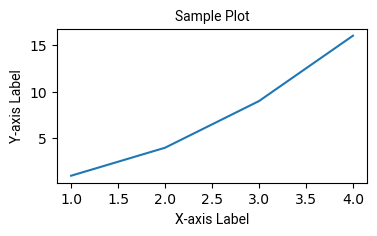

In [4]:
# Select font to use in plots
font_path = r'C:\Users\andre\AppData\Local\Microsoft\Windows\Fonts\Roboto-Regular.ttf'
roboto = font_manager.FontProperties(fname=font_path)

plt.figure(figsize=(4, 2))
# Create a sample plot
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])

# Set the x and y axis labels 
plt.xlabel('X-axis Label', fontproperties=roboto, size=10)
plt.ylabel('Y-axis Label', fontproperties=roboto, size=10)

# Set the plot title 
plt.title('Sample Plot', fontproperties=roboto, size=10)

# Show the plot
plt.show()

## Set Working Directory, Import Datasets, & Review 

In [5]:
# Function to get & set working directory
def set_dir():
    cwd1 = getcwd()
    print(cwd1)
    chdir('C:\\Users\\andre\\Job Portfolio Projects\\DataGlacierVI\\datasets')
    cwd2 = getcwd()
    print(cwd2)

In [6]:
set_dir()

C:\Users\andre\Job Portfolio Projects\DataGlacierVI
C:\Users\andre\Job Portfolio Projects\DataGlacierVI\datasets


In [7]:

# List contents of directory
data_files = listdir()

# Eclude README.md file
if 'README.md' in data_files:
    idx = data_files.index('README.md')
    del data_files[idx]


In [ ]:
data_files

In [8]:
# Import all datasets
df1 = pd.read_csv('Cab_Data.csv')
df2 = pd.read_csv('City.csv')
df3 = pd.read_csv('Customer_ID.csv')
df4 = pd.read_csv('Transaction_ID.csv')

In [ ]:
# Review Meta-data of Cab_Data.csv
display(df1.head())
display(df1.info())
display(df1.shape)

In [ ]:
# Review Meta-data of City.csv
display(df2.head())
display(df2.info())
display(df2.shape)

In [ ]:
# Review Meta-data of Customer_ID.csv
display(df3.head())
display(df3.info())
display(df3.shape)

In [ ]:
# Review Meta-data of Transaction_ID.csv
display(df4.head())
display(df4.info())
display(df4.shape)

## Merge to Create Master DataFrame

In [9]:
# Merge df1 & df4 on 'Transaction ID'
mdf = df1.merge(df4, on='Transaction ID', how='inner')
mdf.head()

Transaction ID  Date of Travel   Company        City  KM Travelled  \
0        10000011           42377  Pink Cab  ATLANTA GA         30.45   
1        10000012           42375  Pink Cab  ATLANTA GA         28.62   
2        10000013           42371  Pink Cab  ATLANTA GA          9.04   
3        10000014           42376  Pink Cab  ATLANTA GA         33.17   
4        10000015           42372  Pink Cab  ATLANTA GA          8.73   

   Price Charged  Cost of Trip  Customer ID Payment_Mode  
0         370.95        313.63        29290         Card  
1         358.52        334.85        27703         Card  
2         125.20         97.63        28712         Cash  
3         377.40        351.60        28020         Cash  
4         114.62         97.78        27182         Card

In [10]:
# Merge master dataframe & df3 on 'Customer ID'
mdf = mdf.merge(df3, on='Customer ID', how='inner')
mdf.head()



Transaction ID  Date of Travel     Company        City  KM Travelled  \
0        10000011           42377    Pink Cab  ATLANTA GA         30.45   
1        10351127           43302  Yellow Cab  ATLANTA GA         26.19   
2        10412921           43427  Yellow Cab  ATLANTA GA         42.55   
3        10000012           42375    Pink Cab  ATLANTA GA         28.62   
4        10320494           43211  Yellow Cab  ATLANTA GA         36.38   

   Price Charged  Cost of Trip  Customer ID Payment_Mode Gender  Age  \
0         370.95        313.63        29290         Card   Male   28   
1         598.70        317.42        29290         Cash   Male   28   
2         792.05        597.40        29290         Card   Male   28   
3         358.52        334.85        27703         Card   Male   27   
4         721.10        467.12        27703         Card   Male   27   

   Income (USD/Month)  
0               10813  
1               10813  
2               10813  
3                9237  
4                9237

In [11]:
# Rename df2 to cdf (city_dataframe)
cdf = df2

## Data Cleansing & Preprocessing

In [12]:
# Check both 'mdf' & 'cdf' for duplicates
def duplicates(df):
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]
    return f'{before-after} duplicates were removed'

In [13]:
duplicates(mdf)

'0 duplicates were removed'

In [14]:
duplicates(cdf)

'0 duplicates were removed'

In [15]:
# Convert capital letters in columns to lowercase for uniformity 
def lowercase(df):
    for i, colname in enumerate(df):
        if df[colname].dtype == 'object':
            df[colname] = df[colname].str.lower()
    return df.head()
    

In [16]:
lowercase(mdf)

Transaction ID  Date of Travel     Company        City  KM Travelled  \
0        10000011           42377    pink cab  atlanta ga         30.45   
1        10351127           43302  yellow cab  atlanta ga         26.19   
2        10412921           43427  yellow cab  atlanta ga         42.55   
3        10000012           42375    pink cab  atlanta ga         28.62   
4        10320494           43211  yellow cab  atlanta ga         36.38   

   Price Charged  Cost of Trip  Customer ID Payment_Mode Gender  Age  \
0         370.95        313.63        29290         card   male   28   
1         598.70        317.42        29290         cash   male   28   
2         792.05        597.40        29290         card   male   28   
3         358.52        334.85        27703         card   male   27   
4         721.10        467.12        27703         card   male   27   

   Income (USD/Month)  
0               10813  
1               10813  
2               10813  
3                9237  
4                9237

In [17]:
lowercase(cdf)

City   Population      Users
0     new york ny   8,405,837    302,149 
1      chicago il   1,955,130    164,468 
2  los angeles ca   1,595,037    144,132 
3        miami fl   1,339,155     17,675 
4  silicon valley   1,177,609     27,247

In [18]:
# Convert missing value representations to NaN, if any
mdf.replace(['n/a', '-999', '?', '###', '-', 'na', 'null'], float('NaN'), inplace=True)
cdf.replace(['n/a', '-999', '?', '###', '-', 'na', 'null'], float('NaN'), inplace=True)
display(mdf.isnull().sum())
display(cdf.isnull().sum())

Transaction ID        0
Date of Travel        0
Company               0
City                  0
KM Travelled          0
Price Charged         0
Cost of Trip          0
Customer ID           0
Payment_Mode          0
Gender                0
Age                   0
Income (USD/Month)    0
dtype: int64

City          0
Population    0
Users         0
dtype: int64

In [19]:
# Rename columns of dataframe
mdf_names = {'Transaction ID':'trans_id', 'Date of Travel':'date', 'Company':'company', 'City':'city', 
             'KM Travelled':'trip_miles', 'Price Charged':'price', 'Cost of Trip':'cost', 'Customer ID':'cust_id', 
             'Payment_Mode':'payment_type', 'Gender':'gender', 'Age':'age', 'Income (USD/Month)':'income'}

# Create a mapper
cdf_names = {'City':'city', 'Population':'pop', 'Users':'users'}

# Rename columns
mdf.rename(columns=mdf_names, inplace=True)
cdf.rename(columns=cdf_names, inplace=True)

# Display
display(mdf.head())
display(cdf.head())

trans_id   date     company        city  trip_miles  price   cost  cust_id  \
0  10000011  42377    pink cab  atlanta ga       30.45 370.95 313.63    29290   
1  10351127  43302  yellow cab  atlanta ga       26.19 598.70 317.42    29290   
2  10412921  43427  yellow cab  atlanta ga       42.55 792.05 597.40    29290   
3  10000012  42375    pink cab  atlanta ga       28.62 358.52 334.85    27703   
4  10320494  43211  yellow cab  atlanta ga       36.38 721.10 467.12    27703   

  payment_type gender  age  income  
0         card   male   28   10813  
1         cash   male   28   10813  
2         card   male   28   10813  
3         card   male   27    9237  
4         card   male   27    9237

city          pop      users
0     new york ny   8,405,837    302,149 
1      chicago il   1,955,130    164,468 
2  los angeles ca   1,595,037    144,132 
3        miami fl   1,339,155     17,675 
4  silicon valley   1,177,609     27,247

In [20]:
km_per_mile = 1.609934

# Transform the 'trip_miles' feature from "km's" to 'miles' 30.45
mdf['trip_miles'] = mdf['trip_miles']/km_per_mile
mdf.head()

trans_id   date     company        city  trip_miles  price   cost  cust_id  \
0  10000011  42377    pink cab  atlanta ga       18.91 370.95 313.63    29290   
1  10351127  43302  yellow cab  atlanta ga       16.27 598.70 317.42    29290   
2  10412921  43427  yellow cab  atlanta ga       26.43 792.05 597.40    29290   
3  10000012  42375    pink cab  atlanta ga       17.78 358.52 334.85    27703   
4  10320494  43211  yellow cab  atlanta ga       22.60 721.10 467.12    27703   

  payment_type gender  age  income  
0         card   male   28   10813  
1         cash   male   28   10813  
2         card   male   28   10813  
3         card   male   27    9237  
4         card   male   27    9237

In [21]:
# Switch Excel date format to standard date format
mdf['date'] = pd.to_datetime('1900-01-01') + pd.to_timedelta(mdf['date'] - 2, unit = 'D')
mdf.head()

trans_id       date     company        city  trip_miles  price   cost  \
0  10000011 2016-01-08    pink cab  atlanta ga       18.91 370.95 313.63   
1  10351127 2018-07-21  yellow cab  atlanta ga       16.27 598.70 317.42   
2  10412921 2018-11-23  yellow cab  atlanta ga       26.43 792.05 597.40   
3  10000012 2016-01-06    pink cab  atlanta ga       17.78 358.52 334.85   
4  10320494 2018-04-21  yellow cab  atlanta ga       22.60 721.10 467.12   

   cust_id payment_type gender  age  income  
0    29290         card   male   28   10813  
1    29290         cash   male   28   10813  
2    29290         card   male   28   10813  
3    27703         card   male   27    9237  
4    27703         card   male   27    9237

In [22]:
# Create quarter labels
qrtr_labels = {1:'Q1', 2:'Q2', 3:'Q3', 4:'Q4'}

# Extract the 'quarter' into a feature column
mdf['quarter'] = pd.to_datetime(mdf['date']).dt.quarter

# Map 'qrtr_labels' to the feature column
mdf['quarter'] = mdf['quarter'].map(qrtr_labels)

# Extract the 'year' into a feature column
mdf['year'] = pd.to_datetime(mdf['date']).dt.year

# Concatenate the 'quarter' and 'year' columns into the 'quarters' feature column
mdf['quarters'] = mdf['quarter'].astype(str) + '-' + mdf['year'].astype(str)

# Display
mdf.head()

trans_id       date     company        city  trip_miles  price   cost  \
0  10000011 2016-01-08    pink cab  atlanta ga       18.91 370.95 313.63   
1  10351127 2018-07-21  yellow cab  atlanta ga       16.27 598.70 317.42   
2  10412921 2018-11-23  yellow cab  atlanta ga       26.43 792.05 597.40   
3  10000012 2016-01-06    pink cab  atlanta ga       17.78 358.52 334.85   
4  10320494 2018-04-21  yellow cab  atlanta ga       22.60 721.10 467.12   

   cust_id payment_type gender  age  income quarter  year quarters  
0    29290         card   male   28   10813      Q1  2016  Q1-2016  
1    29290         cash   male   28   10813      Q3  2018  Q3-2018  
2    29290         card   male   28   10813      Q4  2018  Q4-2018  
3    27703         card   male   27    9237      Q1  2016  Q1-2016  
4    27703         card   male   27    9237      Q2  2018  Q2-2018

In [23]:
def city_state_split(series1, name1, series2, name2):
    # Create a generic list
    lst1 = []
    for city in series1[name1]:
        lst2 = city.split()
        lst1.append(lst2[-1])

    # Create a new Series object 
    state = pd.Series(lst1)
    series2[name2] = state

    # Replace 'state' in the 'city' column
    lst3 = []
    for city in series1[name1]:
        lst4 = city.split()
        del lst4[-1]
        new_city = ' '.join(lst4)
        lst3.append(new_city)
    
    # Create new series
    series1[name1] = lst3
    
    # Replace 'county' & 'valley' with 'ca'
    for i in range(len(series2[name2])):
        if series2[name2][i] == 'county' or series2[name2][i] == 'valley':
            series2.loc[i, name2] = 'ca'


In [24]:
city_state_split(mdf, 'city', mdf, 'state')

# List 'mdf' columns
new_order = ['date', 'trans_id', 'cust_id', 'company', 
             'city', 'state', 'trip_miles', 'price', 
             'cost','payment_type', 'gender', 'age', 
             'income', 'quarter', 'year', 'quarters']

# Reorder 'mdf' columns
mdf = mdf.reindex(columns=new_order)
    
mdf.head()

date  trans_id  cust_id     company     city state  trip_miles  price  \
0 2016-01-08  10000011    29290    pink cab  atlanta    ga       18.91 370.95   
1 2018-07-21  10351127    29290  yellow cab  atlanta    ga       16.27 598.70   
2 2018-11-23  10412921    29290  yellow cab  atlanta    ga       26.43 792.05   
3 2016-01-06  10000012    27703    pink cab  atlanta    ga       17.78 358.52   
4 2018-04-21  10320494    27703  yellow cab  atlanta    ga       22.60 721.10   

    cost payment_type gender  age  income quarter  year quarters  
0 313.63         card   male   28   10813      Q1  2016  Q1-2016  
1 317.42         cash   male   28   10813      Q3  2018  Q3-2018  
2 597.40         card   male   28   10813      Q4  2018  Q4-2018  
3 334.85         card   male   27    9237      Q1  2016  Q1-2016  
4 467.12         card   male   27    9237      Q2  2018  Q2-2018

In [25]:
# Make a profit column
mdf['profit'] = mdf['price'] - mdf['cost']
mdf.head()

date  trans_id  cust_id     company     city state  trip_miles  price  \
0 2016-01-08  10000011    29290    pink cab  atlanta    ga       18.91 370.95   
1 2018-07-21  10351127    29290  yellow cab  atlanta    ga       16.27 598.70   
2 2018-11-23  10412921    29290  yellow cab  atlanta    ga       26.43 792.05   
3 2016-01-06  10000012    27703    pink cab  atlanta    ga       17.78 358.52   
4 2018-04-21  10320494    27703  yellow cab  atlanta    ga       22.60 721.10   

    cost payment_type gender  age  income quarter  year quarters  profit  
0 313.63         card   male   28   10813      Q1  2016  Q1-2016   57.31  
1 317.42         cash   male   28   10813      Q3  2018  Q3-2018  281.28  
2 597.40         card   male   28   10813      Q4  2018  Q4-2018  194.65  
3 334.85         card   male   27    9237      Q1  2016  Q1-2016   23.67  
4 467.12         card   male   27    9237      Q2  2018  Q2-2018  253.98

In [26]:
# Create a 'day-of-the-week' column so we can analyze the busiest days
mdf['day_of_week'] = mdf['date'].dt.day_name().str.lower()
mdf.head()

date  trans_id  cust_id     company     city state  trip_miles  price  \
0 2016-01-08  10000011    29290    pink cab  atlanta    ga       18.91 370.95   
1 2018-07-21  10351127    29290  yellow cab  atlanta    ga       16.27 598.70   
2 2018-11-23  10412921    29290  yellow cab  atlanta    ga       26.43 792.05   
3 2016-01-06  10000012    27703    pink cab  atlanta    ga       17.78 358.52   
4 2018-04-21  10320494    27703  yellow cab  atlanta    ga       22.60 721.10   

    cost payment_type gender  age  income quarter  year quarters  profit  \
0 313.63         card   male   28   10813      Q1  2016  Q1-2016   57.31   
1 317.42         cash   male   28   10813      Q3  2018  Q3-2018  281.28   
2 597.40         card   male   28   10813      Q4  2018  Q4-2018  194.65   
3 334.85         card   male   27    9237      Q1  2016  Q1-2016   23.67   
4 467.12         card   male   27    9237      Q2  2018  Q2-2018  253.98   

  day_of_week  
0      friday  
1    saturday  
2      friday  
3   wednesday  
4    saturday

In [27]:
# We will save 25% of the memory by converting data types from 'object' to 'category' 41.1+ MB --> 29.1 MB
for colname in mdf:
    if mdf[colname].dtype == 'object' and colname != 'day_of_week':
        mdf[colname] = pd.Categorical(mdf[colname], ordered=False)
    
    # Convert 'day_of_week' to ordinal data
    elif mdf[colname].dtype == 'object' and colname == 'day_of_week':
        mdf[colname] = pd.Categorical(mdf[colname], categories=['sunday', 'monday', 'tuesday', 'wednesday',
                                                                'thursday', 'friday', 'saturday'], ordered=True)

mdf.info()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          359392 non-null  datetime64[ns]
 1   trans_id      359392 non-null  int64         
 2   cust_id       359392 non-null  int64         
 3   company       359392 non-null  category      
 4   city          359392 non-null  category      
 5   state         359392 non-null  category      
 6   trip_miles    359392 non-null  float64       
 7   price         359392 non-null  float64       
 8   cost          359392 non-null  float64       
 9   payment_type  359392 non-null  category      
 10  gender        359392 non-null  category      
 11  age           359392 non-null  int64         
 12  income        359392 non-null  int64         
 13  quarter       359392 non-null  category      
 14  year          359392 non-null  int64         
 15  quarters      359

In [28]:
# Create age_labels and bin-edges
age_labels = ['18-24', '25-34', '35-54', '55-64']
age_bins = [17, 25, 35, 55, 65]

# Apply the labels to the 'age' column
mdf['age_category'] = pd.cut(x=mdf['age'], bins=age_bins, labels=age_labels, ordered=True)

# Display
mdf.head()

date  trans_id  cust_id     company     city state  trip_miles  price  \
0 2016-01-08  10000011    29290    pink cab  atlanta    ga       18.91 370.95   
1 2018-07-21  10351127    29290  yellow cab  atlanta    ga       16.27 598.70   
2 2018-11-23  10412921    29290  yellow cab  atlanta    ga       26.43 792.05   
3 2016-01-06  10000012    27703    pink cab  atlanta    ga       17.78 358.52   
4 2018-04-21  10320494    27703  yellow cab  atlanta    ga       22.60 721.10   

    cost payment_type gender  age  income quarter  year quarters  profit  \
0 313.63         card   male   28   10813      Q1  2016  Q1-2016   57.31   
1 317.42         cash   male   28   10813      Q3  2018  Q3-2018  281.28   
2 597.40         card   male   28   10813      Q4  2018  Q4-2018  194.65   
3 334.85         card   male   27    9237      Q1  2016  Q1-2016   23.67   
4 467.12         card   male   27    9237      Q2  2018  Q2-2018  253.98   

  day_of_week age_category  
0      friday        25-34  
1    saturday        25-34  
2      friday        25-34  
3   wednesday        25-34  
4    saturday        25-34

In [29]:
# Use regex to remove commas from 'pop' and 'users'

cdf['pop'] = cdf['pop'].str.replace(r',', '', regex=True).astype('int64')
cdf['users'] = cdf['users'].str.replace(r',', '', regex=True).astype('int64')
cdf.head()

city      pop   users
0     new york ny  8405837  302149
1      chicago il  1955130  164468
2  los angeles ca  1595037  144132
3        miami fl  1339155   17675
4  silicon valley  1177609   27247

In [30]:
# Create feature
cdf['% of users'] = cdf['users']/cdf['pop']
cdf.head()

city      pop   users  % of users
0     new york ny  8405837  302149        0.04
1      chicago il  1955130  164468        0.08
2  los angeles ca  1595037  144132        0.09
3        miami fl  1339155   17675        0.01
4  silicon valley  1177609   27247        0.02

In [31]:
# Use function to separate the city and state to create a new 'state' feature
city_state_split(cdf, 'city', cdf, 'state')

# Sort by 'city' 
cdf.sort_values(by='city', inplace=True)

# Reset the index
cdf.reset_index(drop=True, inplace=True)

# Display
cdf.head()

city      pop   users  % of users state
0  atlanta   814885   24701        0.03    ga
1   austin   698371   14978        0.02    tx
2   boston   248968   80021        0.32    ma
3  chicago  1955130  164468        0.08    il
4   dallas   942908   22157        0.02    tx

In [ ]:
# Customer Reach      2016-01-02 to 2018-12-31 = 2.995 years
# Customer Retention
# Age demographics
# Profit per Mile
# Cost per Mile
# Income Wise Reach
# Ride Count and profit forecasting

In [32]:
# Create profit_margin feature
mdf['profit_margin'] = mdf['profit']/mdf['price']

In [33]:
# Create a dataframe for each companies observations
pcab = mdf[mdf['company'] == 'pink cab']
ycab = mdf[mdf['company'] == 'yellow cab']

## Initial Exploration of Features

In [34]:
# List continuous features
cont_features = ['trip_miles', 'price', 'cost', 'age', 'income', 'profit', 'profit_margin']
cont_features_a = ['trip_miles', 'price', 'ycab_price', 'cost', 'age', 'income', 'profit', 'profits1', 'profit_margin']

# List Categorical
cat_features = ['company', 'city', 'state', 'payment_type', 'gender', 'quarter', 'year', 'quarters' 'day_of_week', 
                'age_category']

In [ ]:
corr_matrix = spcab[cont_features_a].corr()
corr_matrix

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot of Numerical Data')
plt.show()

In [ ]:
# Scatter Plot of all cont_features
#plt.figure(figsize=(20, 20))
plt.xlim(0, max(spcab['ycab_price']))
plt.scatter(spcab['ycab_price'], spcab['profits1'], edgecolor='black')
plt.axhline(y=0, color='red')

In [ ]:
corr_matrix = ycab[cont_features].corr()
corr_matrix

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot of Numerical Data')
plt.show()

In [ ]:
print(len(pcab))
print(len(ycab))
len(ycab)-len(pcab)

In [ ]:
# Scatter Plot of all cont_features
plt.xlim(0, max(ycab['price']))
plt.scatter(ycab['price'], ycab['profit'], edgecolor='black')
plt.axhline(y=0, color='red')

### Outlier Analysis

In [ ]:
# Assuming cont_features is a list of continuous feature column names
# Extract the continuous features into a DataFrame
cont_features_df = mdf[cont_features]

# Instantiate standard scaler object
scaler1 = StandardScaler(with_mean=True, with_std=True, copy=True)

# Fit and transform the DataFrame using StandardScaler
cont_feat_copy = scaler1.fit_transform(cont_features_df)

# Convert the scaled data back to a DataFrame
cont_feat_copy_df = pd.DataFrame(cont_feat_copy, columns=cont_features_df.columns)

# Combine the data into a list or tuple
data = [cont_feat_copy_df['trip_miles'], cont_feat_copy_df['price'], cont_feat_copy_df['cost'], 
        cont_feat_copy_df['income'], cont_feat_copy_df['profit']]

# Create a figure and axes
fig, ax = plt.subplots()

# Create the boxplots
ax.boxplot(data, showmeans=True)

# Add labels to the x-axis tick positions
ax.set_xticklabels(['trip_miles', 'price', 'cost', 'income', 'profit'])

# Add a title and labels
ax.set_facecolor('whitesmoke')
ax.set_title('Continuous Features')
ax.set_xlabel('Data Sets')
ax.set_ylabel('Values')
ax.set_ylim(-5, 9)

# Show the plot
plt.show()



## Save Progress

In [35]:
# Save 'mdf' & rest of progress in 'pickle' format to preserve categories & data types
mdf.to_pickle('mdf.pkl')

# Save 'cdf' & rest of progress in 'pickle' format
mdf.to_pickle('cdf.pkl')

In [ ]:
# set_dir()

In [ ]:
# # Read in 'mdf'
# mdf = pd.read_csv('mdf.csv')

# # Read in 'cdf'
# cdf = pd.read_csv('cdf.csv')

In [ ]:
mdf.info()

In [ ]:
mdf.index = pd.to_datetime(mdf.index)

# Descriptive Statistics

In [ ]:
# Get summary stats from a subset of 'mdf'
ydescriptive = mdf[mdf['company']=='yellow cab'][cont_features].describe()
ydescriptive

In [ ]:
# Get summary stats from a subset of 'mdf'
pdescriptive = mdf[mdf['company'] == 'pink cab'][cont_features].describe()
pdescriptive

In [ ]:
# yellow avg price per mile
yavg_ppm = ydescriptive['price']['mean']/ydescriptive['trip_miles']['mean']
print(yavg_ppm)

# yellow avg cost per mile
yavg_cpm = ydescriptive['cost']['mean']/ydescriptive['trip_miles']['mean']
display(yavg_cpm)

# yellow avg profit per mile
yavg_prpm = ydescriptive['profit']['mean']/ydescriptive['trip_miles']['mean']
display(yavg_prpm)

# pink avg price per mile
pavg_ppm = pdescriptive['price']['mean']/pdescriptive['trip_miles']['mean']
display(pavg_ppm)

# pink avg cost per mile
pavg_cpm = pdescriptive['cost']['mean']/pdescriptive['trip_miles']['mean']
display(pavg_cpm)

# pink avg cost per mile
pavg_prpm = pdescriptive['profit']['mean']/pdescriptive['trip_miles']['mean']
display(pavg_prpm)



In [ ]:
# Number of days in entire data set
tot_num_days = len(mdf.index.unique())
display(tot_num_days)

# Length of a year in days
year_len = 365.25

# Years in data set
display(tot_num_days/year_len)


pink_cab = mdf[mdf['company'] == 'pink cab']
num_pink_fares = len(pink_cab)
display(num_pink_fares)
        
yellow_cab = mdf[mdf['company'] == 'yellow cab']
num_yellow_fares = len(yellow_cab)
display(num_yellow_fares)

# Pink cab profit margin
pink_revenue = pink_cab['price'].sum()
pink_profits = pink_cab['profit'].sum()
pink_profit_margin = pink_profits/pink_revenue
display(pink_profit_margin.round(2))

# SPink cab profit margin
spink_revenue = spcab['ycab_price'].sum()
spink_profits = spcab['profits1'].sum()
spink_profit_margin = spink_profits/spink_revenue
display(spink_profit_margin.round(2))
print('simulated pink profit margin: ', spink_profit_margin)

# Yellow cab profit margin
yellow_revenue = yellow_cab['price'].sum()
yellow_profit = yellow_cab['profit'].sum()
yellow_profit_margin = yellow_profit/yellow_revenue
print('yellow profit margin', yellow_profit_margin.round(2))

# Pink cab avg price per fare
pink_avg_fare = pink_cab['price'].sum()/num_pink_fares
display(pink_avg_fare.round(2))

# Pink avg profit per mile
#pink_avg_prft_mile = 

# Yellow cab avg price per fare
yellow_avg_fare = yellow_cab['price'].sum()/num_yellow_fares
display(yellow_avg_fare.round(2))

# Pinks avg miles per fare
pink_avg_mile = pink_cab['trip_miles'].sum()/num_pink_fares
display(pink_avg_mile.round(2))

# Yellow avg miles per fare
yellow_avg_mile = yellow_cab['trip_miles'].sum()/num_yellow_fares
display(yellow_avg_mile.round(2))

# How many more fares did yellow have over pink
display(yellow_avg_fare/pink_avg_fare)
display(num_yellow_fares - num_pink_fares)


## Does Cab Company Impact Client Frequency?

In [ ]:
# Function to format plots similarly
def format_plot(data, fig, ax, xlab, ylab, title):
    
    # Set font size
    plt.yticks(fontsize=5)

    # Set labels and title
    ax.set_xlabel(xlab, fontproperties=roboto, fontsize=10)
    ax.set_xticks(np.arange(min(data), max(data) + 1), fontsize=7, fontproperties=roboto)
    ax.set_ylabel(ylab, fontproperties=roboto, fontsize=10)
    ax.set_title(f'{title}', fontproperties=roboto, fontsize=12)
    
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)

    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.spines['top'].set_linewidth(.3)
    ax.spines['right'].set_linewidth(.3)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1, 1), prop={'size': 7})

    # Set ax facecolor
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')

    # Set the background color of the figure
    ax.set_facecolor('whitesmoke') 

    # Set the color of the plot perimeter (spines)
    perimeter_color = 'black'  # Set the desired perimeter color
    ax.spines['top'].set_color(perimeter_color)
    ax.spines['right'].set_color(perimeter_color)
    ax.spines['bottom'].set_color(perimeter_color)
    ax.spines['left'].set_color(perimeter_color)

    # Display the plot
    plt.tight_layout()
    plt.grid(True, linewidth=.1, color='black')
    plt.show()
  

## Separate Customers According to Cab Company Choice

In [ ]:
# Create a dictionary to store the sub dataframes
sub_dfs = {}

# Group the master dataframe by customer ID and aggregate unique cab companies as a list
grouped = mdf.groupby('cust_id')['company'].unique().reset_index()

# Rename the column for clarity
grouped.rename(columns={'company': 'unique_companies'}, inplace=True)

# Convert the unique_companies column to a list
grouped['unique_companies'] = grouped['unique_companies'].apply(list)

lst1 = []
lst2 = []
lst3 = []

for lst in grouped.iterrows():    
    if len(lst[1][1]) == 1 and lst[1][1][0] == 'pink cab':
        lst1.append(lst[1][0])
    elif len(lst[1][1]) == 1 and lst[1][1][0] == 'yellow cab':
        lst3.append(lst[1][0])
    elif len(lst[1][1]) == 2:
        lst2.append(lst[1][0])

# Create separate dataframes based on the customer lists
pcab0 = mdf[mdf['cust_id'].isin(lst1)]
ycab0 = mdf[mdf['cust_id'].isin(lst3)]
pcabycab = mdf[mdf['cust_id'].isin(lst2)]

print(len(pcab0) == len(lst1))
print(len(ycab0))
print(len(pcabycab))


grouped.head()

In [ ]:
print(len(pcab0))
print(len(ycab0))
print(len(pcabycab))

In [ ]:
grouped

In [ ]:
pcab0.describe()

In [ ]:
ycab0.describe()

In [ ]:
pcabycab.describe()

In [ ]:
# bar label function 

In [ ]:

def bar_labels(ax, bins, patches, total_samples):
    for b, p in zip(bins, patches):
        height = p.get_height()
        percentage = (height / total_samples) 
        x = p.get_x() + p.get_width() / 2
        formatted_percentage = f"{percentage:.2f}"
        ax.text(x, height, formatted_percentage, ha='center', va='bottom', fontsize=5)




In [ ]:
# Group the data
rides_by_cust = mdf.groupby(['cust_id', 'company']).size().unstack(fill_value=0)

# Separate the ride counts for Pink Cab and Yellow Cab
prides_by_cust = pcab0.groupby(['cust_id', 'company']).size().unstack(fill_value=0)
yrides_by_cust = ycab0.groupby(['cust_id', 'company']).size().unstack(fill_value=0)
pcabycabrides_by_cust = pcabycab.groupby(['cust_id', 'company']).size().unstack(fill_value=0)



In [ ]:
prides_by_cust = prides_by_cust['pink cab']
yrides_by_cust = yrides_by_cust['yellow cab']


pcaby_rides_by_cust = pcabycabrides_by_cust['pink cab']
ycabp_rides_by_cust = pcabycabrides_by_cust['yellow cab']

In [ ]:
# Create a figure with two subplots (one on top of another)
fig1, ax1 = plt.subplots(figsize=(8, 3), dpi=150)

# Create histograms for each subplot
n1 = len(prides_by_cust)
print(f'{n1} customers only took rides with Pink Cab')
bins1 = np.arange(min(prides_by_cust) - 0.5, max(prides_by_cust) + 1.5, 1)
hist1, bins0, patches0 = ax1.hist(prides_by_cust, bins=bins1, color='pink', edgecolor='black', linewidth=0.3, zorder=4)
bar_labels(ax1, hist1, patches0, n1)
format_plot(prides_by_cust, fig, ax1, "Fare's", 'Number of Clients', 'Number of Fares for Clients Who Only Ride Pink Cab' )

fig1.savefig('pink_cab_only_ridership.png')

# Histogram of both cab company 
fig2, ax2 = plt.subplots(figsize=(8, 3), dpi=150)

n2 = len(yrides_by_cust)
print(f'{n2} customers only took rides with Yellow Cab')
bins2 = np.arange(min(yrides_by_cust) - 0.5, max(yrides_by_cust) + 1.5, 1)
hist2, bins1, patches1 = ax2.hist(yrides_by_cust, bins=bins2, color='yellow', edgecolor='black', linewidth=0.3, zorder=4)
bar_labels(ax2, hist2, patches1, n2)
format_plot(yrides_by_cust, fig, ax2, "Fare's", 'Number of Clients', "Number of Fare's for Clients Who Only Ride Yellow Cab")

fig2.savefig('yellow_cab_only_ridership.png')

In [ ]:
# Create a figure with two subplots (one on top of another)
fig3, ax3 = plt.subplots(figsize=(8, 3), dpi=150)

# Create histograms for each subplot
n3 = len(pcaby_rides_by_cust)
print(f'{n3} of Pink Cab')
bins1 = np.arange(min(pcaby_rides_by_cust) - 0.5, max(pcaby_rides_by_cust) + 1.5, 1)
hist3, bins2, patches2 = ax3.hist(prides_by_cust, bins=bins1, color='pink', edgecolor='black', linewidth=0.3, zorder=4)
bar_labels(ax3, hist3, patches2, n3)
format_plot(pcaby_rides_by_cust, fig3, ax3, "Fare's", 'Number of Clients', "Number of Fare's over Three Years" )

fig3.savefig('p_riders_of_p_and_y_riders.png')


# Histogram of both cab company 
fig4, ax4 = plt.subplots(figsize=(8, 3), dpi=150)

# Create histograms for each subplot
n4 = len(ycabp_rides_by_cust)
print(f'{n4} of Yellow Cab')
bins2 = np.arange(min(ycabp_rides_by_cust) - 0.5, max(ycabp_rides_by_cust) + 1.5, 1)
hist4, bins3, patches3 = ax4.hist(yrides_by_cust, bins=bins2, color='yellow', edgecolor='black', linewidth=0.3, zorder=4)
bar_labels(ax4, hist4, patches3, n4)
format_plot(ycabp_rides_by_cust, fig4, ax4, "Fare's", 'Number of Clients', "Number of Fare's over Three Years")

fig4.savefig('y_riders_of_p_and_y_riders.png')

In [ ]:
# Inferences:

# Pink Cab seems to attract more one-time users compared to Yellow Cab.
# Yellow Cab has a higher proportion of repeat users among customers who took rides exclusively with it.
# Among customers who tried both cab companies, a higher percentage of them took only 1 ride with Yellow Cab,
# which could suggest that Yellow Cab has a slightly better retention rate for these users.

## More Descriptive Statistics

In [ ]:
ynum_cust = mdf[mdf['company'] == 'yellow cab']['cust_id'].unique()
display(len(ynum_cust))

pnum_cust = mdf[mdf['company'] == 'pink cab']['cust_id'].unique()
display(len(pnum_cust))

print(f'Yellow Cab Company has {len(ynum_cust) - len(pnum_cust)} more unique customers than Pink Cab Company')

# Why do they have more customers?


In [ ]:
# Avg num of trips every 3 years

ynum_trips = mdf[mdf['company'] == 'yellow cab']['cust_id'].value_counts()
np.mean(ynum_trips)

In [ ]:
# Avg num of trips every 3 years

pnum_trips = mdf[mdf['company'] == 'pink cab']['cust_id'].value_counts()
np.mean(pnum_trips)

In [ ]:
# Yellow cab one time customers
yone_time_cust = mdf[mdf['company']=='yellow cab']['cust_id'].value_counts().eq(1).sum()
display(yone_time_cust)

# one time customers as percentage of total customers
display(yone_time_cust/len(ynum_cust))

In [ ]:
# Pink cab one time customers
pone_time_cust = mdf[mdf['company']== 'pink cab']['cust_id'].value_counts().eq(1).sum()
pone_time_cust

# Pink Cab one time customers as percentage of total customers
display(pone_time_cust/len(pnum_cust))

## Profitability

In [36]:
mdf = mdf.sort_values(by='date').reset_index(drop=True)
mdf.head()

date  trans_id  cust_id     company       city state  trip_miles  \
0 2016-01-02  10000600     3363  yellow cab    chicago    il       14.75   
1 2016-01-02  10000171    20687    pink cab  san diego    ca        8.87   
2 2016-01-02  10000640     4844  yellow cab    chicago    il        9.69   
3 2016-01-02  10001242    14513  yellow cab    silicon    ca       11.19   
4 2016-01-02  10000434    59961  yellow cab     boston    ma       28.10   

   price   cost payment_type gender  age  income quarter  year quarters  \
0 531.25 336.30         cash   male   31   23320      Q1  2016  Q1-2016   
1 269.15 147.08         cash   male   39    8926      Q1  2016  Q1-2016   
2 374.66 209.66         cash   male   32    5548      Q1  2016  Q1-2016   
3 658.65 240.03         card   male   62    3892      Q1  2016  Q1-2016   
4 971.09 564.60         card   male   61   12377      Q1  2016  Q1-2016   

   profit day_of_week age_category  profit_margin  
0  194.95    saturday        25-34           0.37  
1  122.07    saturday        35-54           0.45  
2  165.00    saturday        25-34           0.44  
3  418.62    saturday        55-64           0.64  
4  406.49    saturday        55-64           0.42

In [37]:
mdf = mdf.set_index(keys='date', drop=True)
mdf.head()

trans_id  cust_id     company       city state  trip_miles  price  \
date                                                                            
2016-01-02  10000600     3363  yellow cab    chicago    il       14.75 531.25   
2016-01-02  10000171    20687    pink cab  san diego    ca        8.87 269.15   
2016-01-02  10000640     4844  yellow cab    chicago    il        9.69 374.66   
2016-01-02  10001242    14513  yellow cab    silicon    ca       11.19 658.65   
2016-01-02  10000434    59961  yellow cab     boston    ma       28.10 971.09   

             cost payment_type gender  age  income quarter  year quarters  \
date                                                                        
2016-01-02 336.30         cash   male   31   23320      Q1  2016  Q1-2016   
2016-01-02 147.08         cash   male   39    8926      Q1  2016  Q1-2016   
2016-01-02 209.66         cash   male   32    5548      Q1  2016  Q1-2016   
2016-01-02 240.03         card   male   62    3892      Q1  2016  Q1-2016   
2016-01-02 564.60         card   male   61   12377      Q1  2016  Q1-2016   

            profit day_of_week age_category  profit_margin  
date                                                        
2016-01-02  194.95    saturday        25-34           0.37  
2016-01-02  122.07    saturday        35-54           0.45  
2016-01-02  165.00    saturday        25-34           0.44  
2016-01-02  418.62    saturday        55-64           0.64  
2016-01-02  406.49    saturday        55-64           0.42

In [38]:
# Group the data according to 'weekly' profits
cab_prfts = mdf.groupby(['company'])['profit'].resample('W').agg({'profit':'sum'})
cab_costs = mdf.groupby(['company'])['cost'].resample('W').agg({'cost': 'sum'})
cab_price = mdf.groupby(['company'])['price'].resample('W').agg({'price': 'sum'})

# Merge the three DataFrames
df1 = pd.concat([cab_price, cab_costs, cab_prfts], axis=1)
df1.columns = ['price', 'cost', 'profit']

# Reset index of the DataFrame
df1 = df1.reset_index()

# Pivot the DataFrame
df1 = df1.pivot(index='date', columns='company')

# Flatten the column multi-index
df1.columns = [' '.join(col).strip() for col in df1.columns.values]

# Re-arrange the columns
mapper = {
    'price pink cab': 'pink cab price',
    'price yellow cab': 'yellow cab price',
    'cost pink cab': 'pink cab cost',
    'cost yellow cab': 'yellow cab cost',
    'profit pink cab': 'pink cab profit',
    'profit yellow cab': 'yellow cab profit'
}

df1.rename(mapper, axis=1, inplace=True)

df1 = df1[['pink cab price', 'pink cab cost', 'pink cab profit', 'yellow cab price', 'yellow cab cost', 'yellow cab profit']]


In [39]:
# Define quarter lines
quarter_lines = [
    
    
    {'x0': '2016-04-01', 'x1': '2016-04-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2016-07-01', 'x1': '2016-07-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2016-10-01', 'x1': '2016-10-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2017-01-01', 'x1': '2017-01-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2017-04-01', 'x1': '2017-04-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2017-07-01', 'x1': '2017-07-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2017-10-01', 'x1': '2017-10-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2018-01-01', 'x1': '2018-01-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2018-04-01', 'x1': '2018-04-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2018-07-01', 'x1': '2018-07-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'},
    {'x0': '2018-10-01', 'x1': '2018-10-01', 'y0': 0, 'y1': 1, 'line_width': .2, 'line_dash': 'dash'}
]

quarter_labels = ['Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3']


# Define colors for the traces
colors = ['hotpink', 'hotpink', 'lightsteelblue', 'yellow', 'yellow', 'lightsteelblue']
labels = ['Price: top', 'Cost: bottom', 'Profit:blue area', 'Price: top', 'Cost: bottom', 'Profit:blue area']


shapes = [
    dict(
        type='line',
        xref='x',
        yref='paper',
        x0=line['x0'],
        x1=line['x1'],
        y0=0,
        y1=1,
        line_width=line['line_width'],
        line_dash=line['line_dash'],
    ) for line in quarter_lines
]


annotations = [
    dict(
        x=line['x0'],
        y=1.05,
        xref='x',
        yref='paper',
        text=label,
        showarrow=False,
        font=dict(size=10),
    ) for line, label in zip(quarter_lines, quarter_labels)
]

font_style = {'family': 'Roboto', 'size': 12}

In [ ]:
list_mpl_colors()

In [40]:

# Create a subplot with two rows and one column
fig = make_subplots(rows=2, cols=1, shared_xaxes=False)


# Add multiple time series traces to the first subplot (row 1)

for i in range(0, 3):
    if i == 1:
        fill='tonexty'
    elif i == 2:
        fill='tozeroy'
    else:
        fill='none'
        
    column_name = df1.columns[i]
    
    trace = go.Scatter(x=df1.index[2:-2], 
                       y=df1[column_name], 
                       mode='lines', 
                       name=f'{labels[i]}', 
                       line={'width': 1.25, 'color': colors[i]},
                       fill=fill,
                       showlegend=True)
    
    fig.add_trace(trace, row=1, col=1)
    
# Add multiple time series traces to the second subplot (row 2)
for i in range(3, 6):
    if i == 4:
        fill='tonexty'
    elif i == 5:
        fill='tozeroy'
    else:
        fill='none'
    
    column_name = df1.columns[i]
    
    trace = go.Scatter(x=df1.index[2:-2], 
                       y=df1[column_name], 
                       mode='lines', 
                       name=f'{labels[i]}', 
                       line={'width': 1.25, 'color': colors[i]},
                       fill=fill,
                       showlegend=True)
    
    fig.add_trace(trace, row=2, col=1)
    

# Customize the layout
fig.update_layout(
    title='CAB COMPANY PROFITABILITY',
    title_font_size=18,
    xaxis_title='Date',
    template="ggplot2",
    showlegend=True,  
    legend=dict(x=1.25, xanchor='right', y=1, yanchor='top'),
    margin=dict(t=100, b=100),  
    height=500,  
    width=800,   
    shapes=shapes,
    annotations=annotations,
    plot_bgcolor='white', 
    paper_bgcolor='silver'  
)


# Update properties for the second subplot (row 2)
fig.update_xaxes(title_text='Date', row=1, col=1, title_font=font_style, tickfont=font_style, showgrid=False)
fig.update_yaxes(type='log', row=1, col=1, title_text='Log₁₀ - $USD', title_font=font_style, tickfont=font_style, 
                 showgrid=False)
fig.update_xaxes( title_text='Date', row=2, col=1,title_font=font_style, tickfont=font_style, showgrid=False)
fig.update_yaxes(type='log', row=2, col=1, title_text='Log₁₀ - $USD', title_font=font_style, tickfont=font_style, 
                 showgrid=False)


# Show the plot
fig.show()



# Calculate profit margins
industry_profit_margin = mdf['profit'].sum()/mdf['price'].sum()
yellow_profit_margin = mdf[mdf['company'] == 'yellow cab']['profit'].sum()/mdf[mdf['company'] == 'yellow cab']['price'].sum()
pink_profit_margin = mdf[mdf['company'] == 'pink cab']['profit'].sum()/mdf[mdf['company'] == 'pink cab']['price'].sum()

print(industry_profit_margin.round(2))
print(yellow_profit_margin.round(2))
print(pink_profit_margin.round(2))

0.32
0.35
0.2


## Forecasting Profits: Time-Series

In [41]:
# Aggregate data
profit_series = mdf.groupby('company')['profit'].resample('W').sum()
profit_df = profit_series.unstack(level='company')

# Separate individual series for easier coding and identification
pprofits = profit_df['pink cab']
yprofits = profit_df['yellow cab']


## Time Series Decomposition: Identifying Seasonal & Overall Trend

In [42]:
# Decompose the time series

pdecomp = sm.tsa.seasonal_decompose(pprofits, model='additive', period=52, filt=None,
                                    two_sided=True, extrapolate_trend='freq')

ydecomp = sm.tsa.seasonal_decompose(yprofits, model='additive', period=52, filt=None, 
                                   two_sided=True, extrapolate_trend='freq')

ptrend = pdecomp.trend.dropna()
pseasonal = pdecomp.seasonal.dropna()
presiduals = pdecomp.resid.dropna()

ytrend = ydecomp.trend.dropna()
yseasonal = ydecomp.seasonal.dropna()
yresiduals = ydecomp.resid.dropna()


In [103]:
# Function to format plots similarly
def format_plot(data, fig, ax, xlab, ylab, title):
    
    # Set font size
    plt.yticks(fontsize=5)

    # Set labels and title
    ax.set_xlabel(xlab, fontproperties=roboto, fontsize=10)
    #ax.set_xticks(np.arange(min(data), max(data) + 1), fontsize=7, fontproperties=roboto)
    ax.set_ylabel(ylab, fontproperties=roboto, fontsize=10)
    ax.set_title(f'{title}', fontproperties=roboto, fontsize=12)
    
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)

#     # Hide the right and top spines
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.spines['top'].set_linewidth(.3)
    ax.spines['right'].set_linewidth(.3)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1, 1), prop={'size': 7})

    # Set ax facecolor
    ax = plt.gca()
    ax.set_facecolor('white')

    # Set the figure face color
    fig.set_facecolor('#ffff66')
# pink: '#ff87a0'
# yellow: '#ffff66'
    # Set the background color of the figure
    #fig.set_facecolor('lightblue') 

    # Set the color of the plot perimeter (spines)
    perimeter_color = 'black'  # Set the desired perimeter color
    ax.spines['top'].set_color(perimeter_color)
    ax.spines['right'].set_color(perimeter_color)
    ax.spines['bottom'].set_color(perimeter_color)
    ax.spines['left'].set_color(perimeter_color)

    # Display the plot
    plt.tight_layout()
    plt.grid(True, linewidth=.1, color='black')
    plt.tight_layout()
  

In [ ]:
pink_colors = ['#ff87a0', '#e65c75', '#d93c53', '#c1223d', '#ff6699', '#ff4d6a', '#ff3350', '#ff1a37',
               '#ffcccc', '#ff9999', '#ff6666', '#ff3333', '#ffb3b3', '#ff8080', '#ff4d4d', '#ff1a1a',
               '#ffd9d9', '#ffad99', '#ff8066', '#ff5533', '#ffe0cc', '#ffb299', '#ff804d', '#ff4d00']

yellow_colors = ['#ffeb88', '#ffd43f', '#ffcc00', '#ffaa00', '#ffff99', '#ffff66', '#ffff33', '#ffff00',
                 '#ffffcc', '#ffff99', '#ffff66', '#ffff33', '#ffcc00', '#ffaa00', '#ff8800', '#ff6600',
                 '#fff2cc', '#ffe699', '#ffdd66', '#ffcc33', '#fff5cc', '#fff0b3', '#ffeb99', '#ffe580']


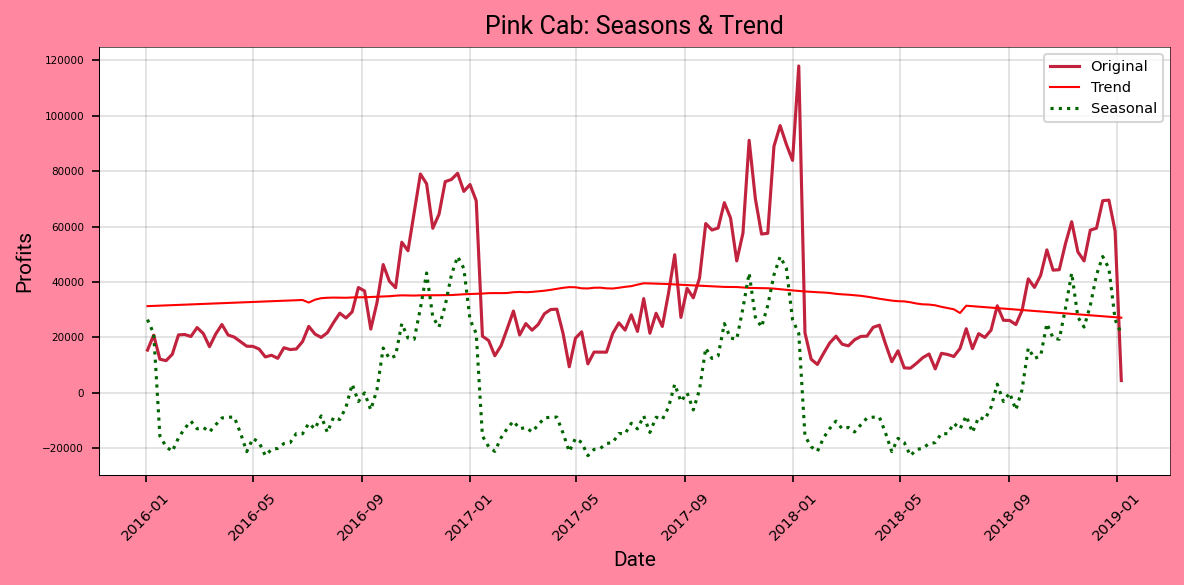

In [92]:

# ## > Pink seasonal decomposition

fig3, ax3 = plt.subplots(figsize=(8, 4), dpi=150)



ax3.plot(pprofits, label='Original', linewidth=1.5, color='#c1223d')
ax3.plot(pprofits.index, ptrend, label='Trend', linestyle='solid', linewidth=1, color='red')
ax3.plot(pprofits.index, pseasonal, label='Seasonal', linestyle='dotted', linewidth=1.5, color='darkgreen')
format_plot(pprofits, fig3, ax3, 'Date', 'Profits', 'Pink Cab: Seasons & Trend')

# fig4, ax4 = plt.subplots(figsize=(8, 4), dpi=150)
# ax4.plot(pprofits.index, presiduals, label='Residual', linewidth=1)
# format_plot(pprofits, fig4, ax4, 'Date', 'Profits', 'Pink Cab: Residuals')

fig3.savefig('pink_profit_trend.png')


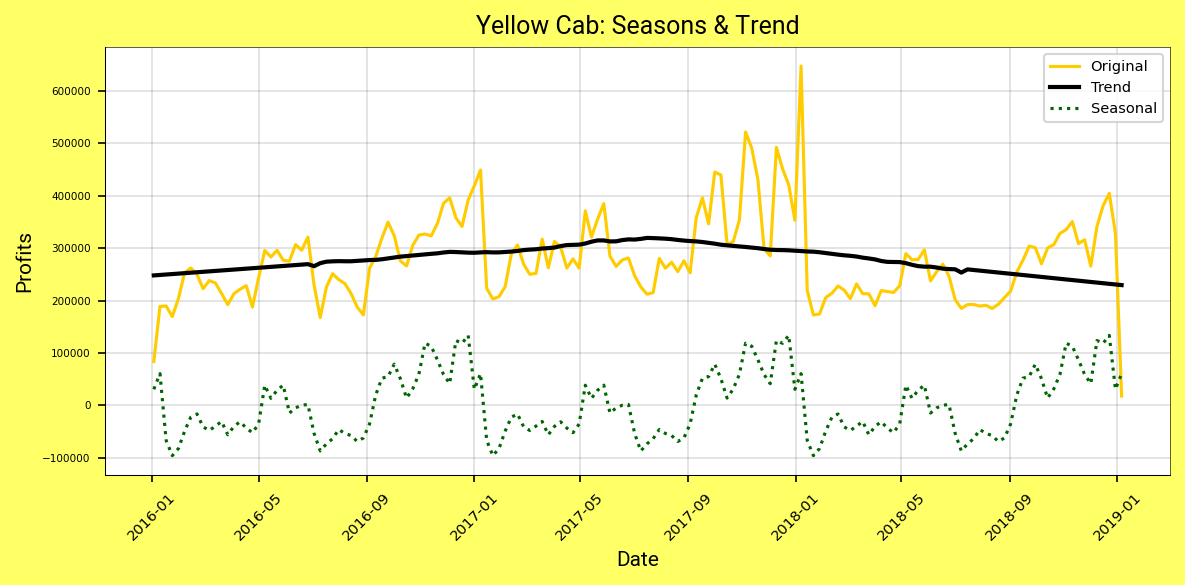

In [195]:

# ## > Yellow seasonal decomposition

fig5, ax5 = plt.subplots(figsize=(8, 4), dpi=150)

ax5.plot(yprofits, label='Original', linewidth=1.5, color='#ffcc00')
ax5.plot(yprofits.index, ytrend, label='Trend', linestyle='solid', linewidth=2, color='black')
ax5.plot(yprofits.index, yseasonal, label='Seasonal', linestyle='dotted', linewidth=1.5, color='darkgreen')
format_plot(yprofits, fig5, ax5, 'Date', 'Profits', 'Yellow Cab: Seasons & Trend')

# fig6, ax6 = plt.subplots(figsize=(8, 4), dpi=150)

# ax6.plot(yprofits.index, yresiduals, label='Residual', linewidth=1)
# format_plot(yprofits, fig6, ax6, 'Date', 'Profits', 'Yellow Cab: Seasons & Trend')

fig5.savefig('yellow_profit_trend.png')

## Estimating Pink Cab Trend Coefficients

In [93]:
# Add a constant term to the independent variable (trend)
X = sm.add_constant(ptrend)

# Fit a linear regression model
model = sm.OLS(pprofits, X)
results = model.fit()

# Get the regression coefficients
intercept, slope = results.params

# Print the coefficients
print("Intercept:", intercept)
print("Slope (Coefficient):", slope, '\n')

# R-squared
print(f'R-Squared: {results.rsquared} ')

Intercept: 74.27790462041094
Slope (Coefficient): 0.9770054376728654 

R-Squared: 0.019667358849381422 


A, B, C = [-1.56745539e+00  2.26683728e+02  2.94303202e+04]

R-squared: 0.8969648915122493


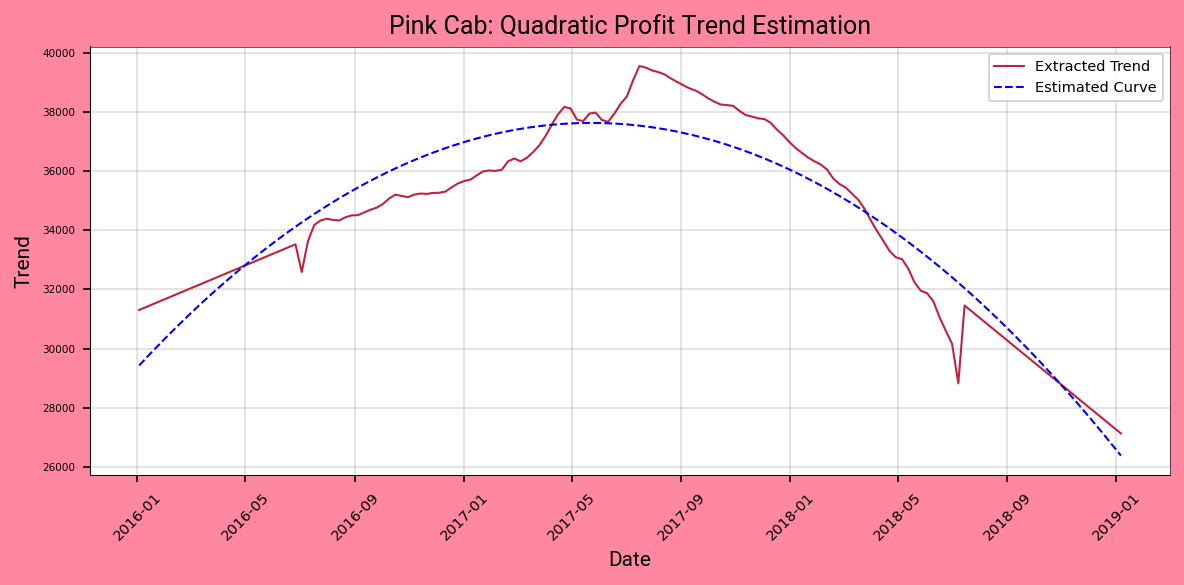

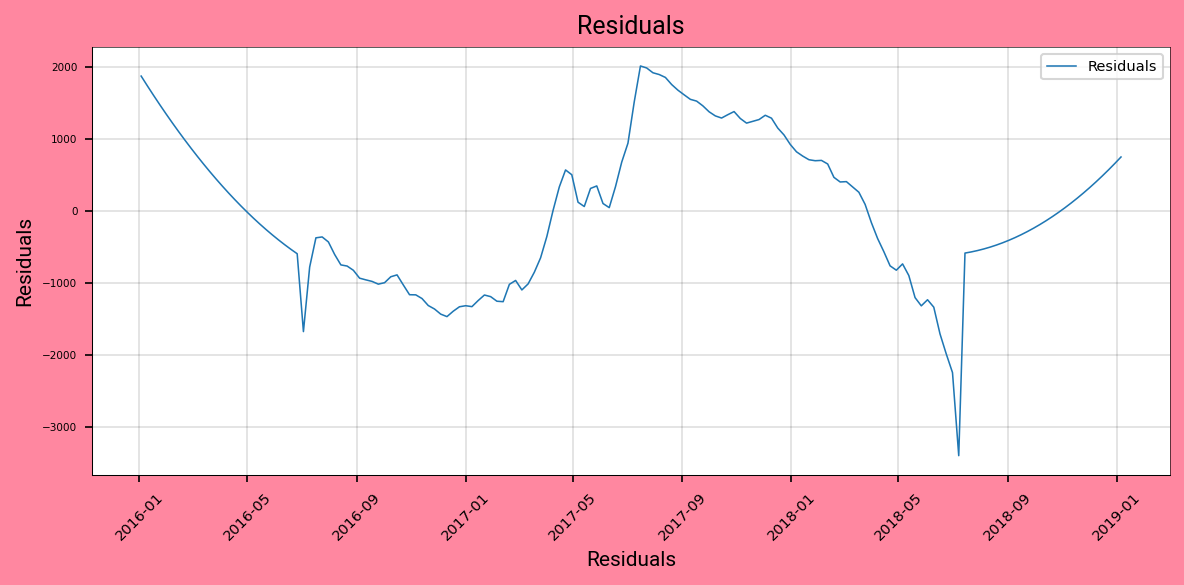

In [99]:
from scipy.optimize import curve_fit

# Convert DatetimeIndex to numerical values
x_values = np.arange(len(ptrend))


# Define the quadratic function
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the quadratic function to the numerical x_values using scipy.optimize.curve_fit
params, _= curve_fit(quadratic_func, x_values, ptrend)

# Generate the values of the quadratic curve
quadratic_curve = quadratic_func(x_values, *params)

# Calculate residuals (differences between original data and fitted curve)
pquad_resid = ptrend - quadratic_curve




# Plot the original data and the quadratic curve
fig6, ax6 = plt.subplots(figsize=(8, 4), dpi=150)

ax6.plot(ptrend.index, ptrend, label='Extracted Trend', linewidth=1, color='#c1223d')
ax6.plot(ptrend.index, quadratic_curve, label='Estimated Curve', linestyle='dashed', linewidth=1, color='blue')
format_plot(ptrend, fig6, ax6, 'Date', 'Trend', 'Pink Cab: Quadratic Profit Trend Estimation')

fig6.savefig('pink_quadratic trend.png')
print(f'A, B, C = {params}')




fig7, ax7 = plt.subplots(figsize=(8, 4), dpi=150)

plt.plot(ptrend.index, pquad_resid, label='Residuals', linewidth=.75)
format_plot(ptrend, fig7, ax7, 'Residuals', 'Residuals', 'Residuals')

# Calculate R-Squared value
sst = np.sum((ptrend - np.mean(ptrend))**2)
ssr = np.sum(pquad_resid**2)
r_squared = 1 - (ssr / sst)
print("\nR-squared:", r_squared)


## Estimating Yellow Cab Trend Coefficients

In [100]:
# Add a constant term to the independent variable (trend)
X = sm.add_constant(ytrend)

# Fit a linear regression model
model = sm.OLS(yprofits, X)
results = model.fit()

# Get the regression coefficients
intercept, slope = results.params

# Print the coefficients
print("Intercept:", intercept)
print("Slope (Coefficient):", slope, '\n')

# R-squared
print(f'R-Squared: {results.rsquared} ')


Intercept: -4625.07629115149
Slope (Coefficient): 1.015068177737436 

R-Squared: 0.08846372701925487 


A, B, C = [-1.22501789e+01  1.83046549e+03  2.36311110e+05]
R-squared: 0.9993092410489578


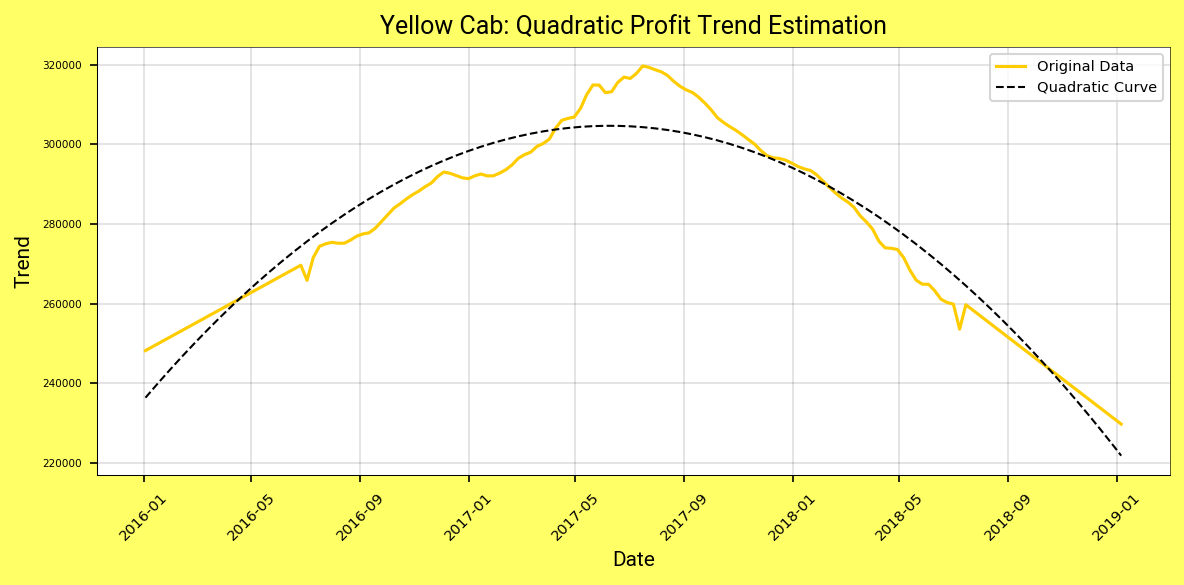

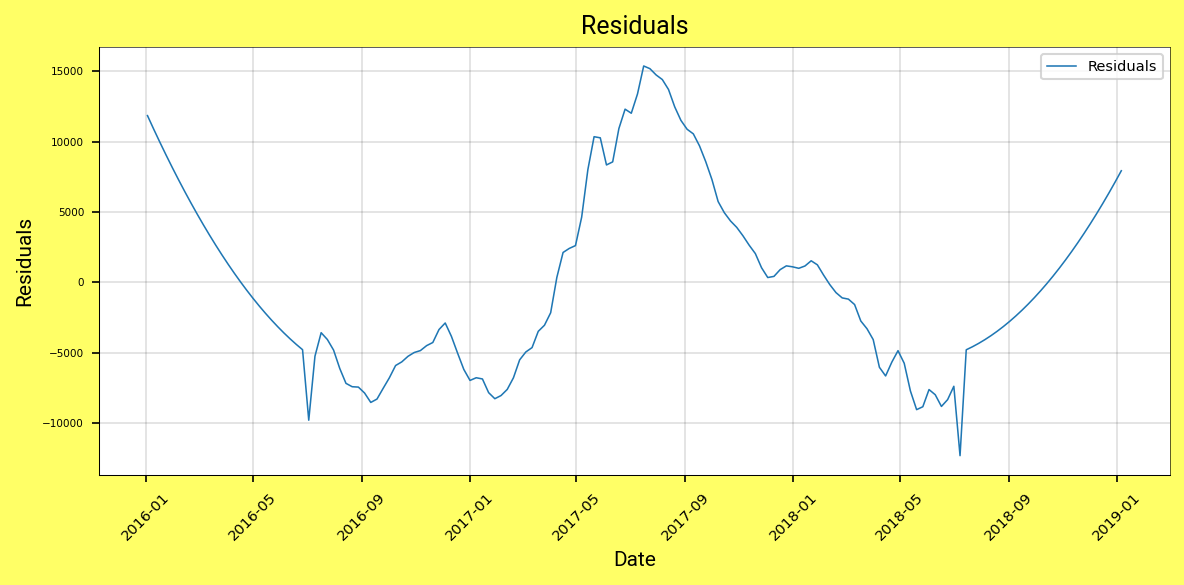

In [105]:
from scipy.optimize import curve_fit

# Convert DatetimeIndex to numerical values
x_values = np.arange(len(ytrend))


# Define the quadratic function
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the quadratic function to the numerical x_values using scipy.optimize.curve_fit
params, _= curve_fit(quadratic_func, x_values, ytrend)

# Generate the values of the quadratic curve
quadratic_curve = quadratic_func(x_values, *params)

# Calculate residuals (differences between ytrend data and fitted curve)
yquad_resid = ytrend - quadratic_curve


# Create figure
fig8, ax8 = plt.subplots(figsize=(8, 4), dpi=150)


plt.plot(ytrend.index, ytrend, label='Original Data', linewidth=1.5, color='#ffcc00')
plt.plot(ytrend.index, quadratic_curve, label='Quadratic Curve', linestyle='dashed', linewidth=1, color='black')
format_plot(ytrend, fig8, ax8, 'Date', 'Trend', 'Yellow Cab: Quadratic Profit Trend Estimation')

fig8.savefig('yellow_quaratic_trend.png')
# Print parameters
print(f'A, B, C = {params}')

fig9, ax9 = plt.subplots(figsize=(8, 4), dpi=150)

# Plot the residuals from the curve fitting
plt.plot(ytrend.index, yquad_resid, label='Residuals', linewidth=.75)
format_plot(ytrend, fig9, ax9, 'Date', 'Residuals', 'Residuals')

# Calculate R-Squared value
sst = np.sum((ytrend - np.mean(ptrend))**2)
ssr = np.sum(yquad_resid**2)
r_squared = 1 - (ssr / sst)
print("R-squared:", r_squared)

# Stationarity

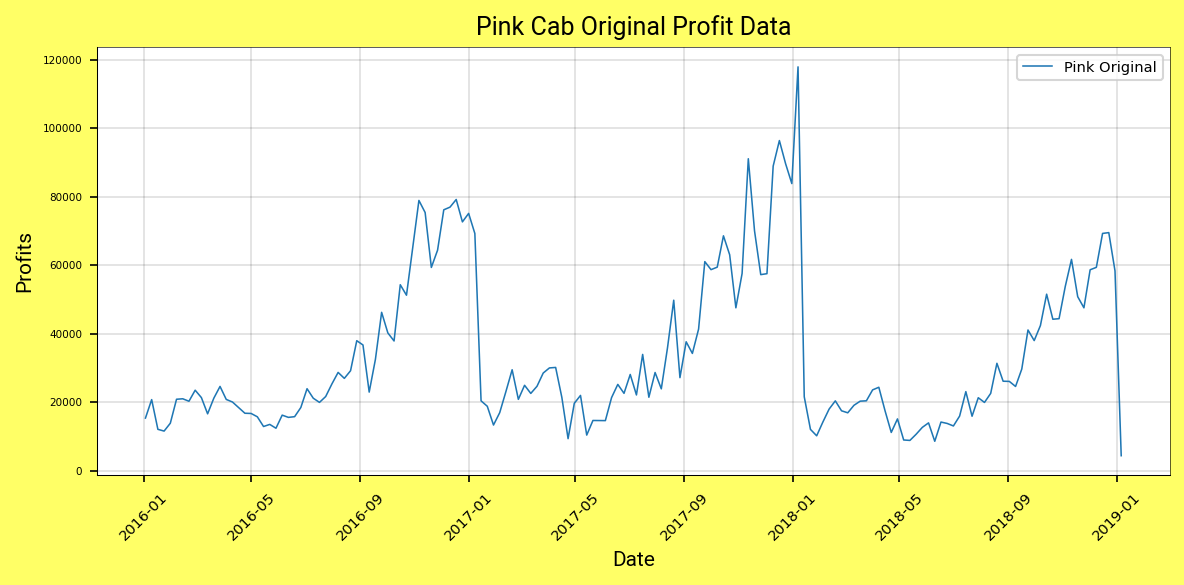

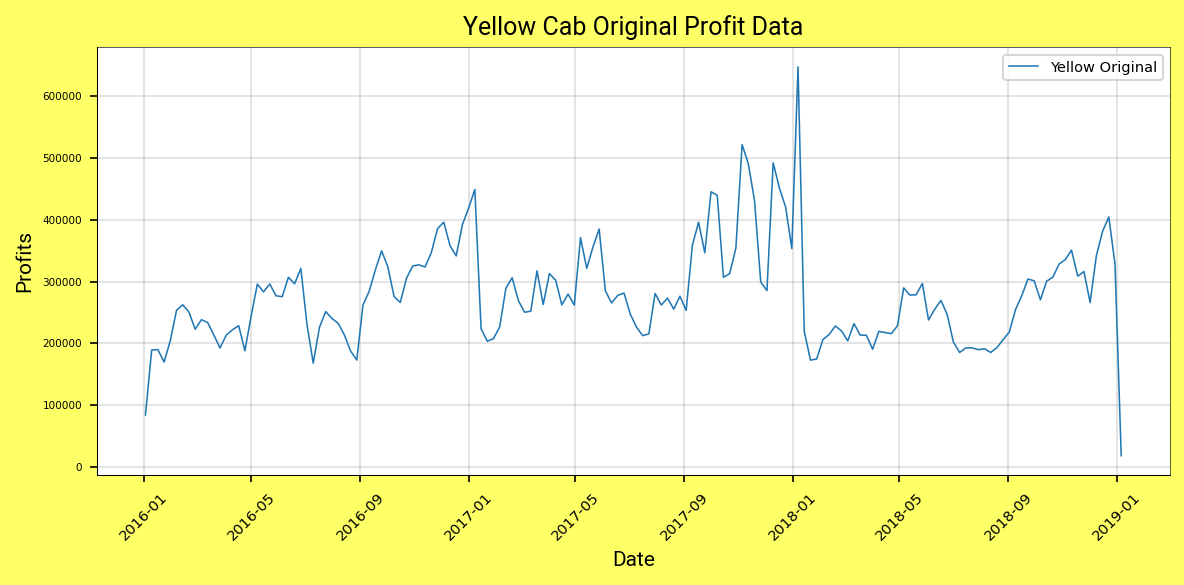

In [106]:
# Plot figure
fig10, ax10 = plt.subplots(figsize=(8, 4), dpi=150)

# Plot original data
plt.plot(pprofits, label='Pink Original', linewidth=.75)
format_plot(pprofits, fig10, ax10, 'Date', 'Profits', 'Pink Cab Original Profit Data')

fig11, ax11 = plt.subplots(figsize=(8, 4), dpi=150)
plt.plot(yprofits, label='Yellow Original', linewidth=.75)
format_plot(yprofits, fig11, ax11, 'Date', 'Profits', 'Yellow Cab Original Profit Data')

## Pink Cab Stationarity: First Order & Seasonal Differencing, & ADF Test

In [107]:
# Fit the rolling mean & standard deviations
window_size = 12

pmove_avg = pprofits.rolling(window=window_size, min_periods=1).mean()
pmove_std = pprofits.rolling(window=window_size, min_periods=1).std()

In [ ]:
fig12, ax12 = plt.subplots(figsize=(8, 4), dpi=150)

plt.plot(pprofits, label='Profits', linewidth=.75)
plt.plot(pprofits.index, pmove_avg, label='Moving Average', linestyle='dashed', color='red', linewidth=.75)
plt.plot(pprofits.index, pmove_std, label='Moving Standard Deviation', linestyle='dotted', color='green', linewidth=.75)
format_plot(pprofits, fig12, ax12, '', '', 'Characteristics of Mean & Standard Deviation of Data with Seasonal Component')


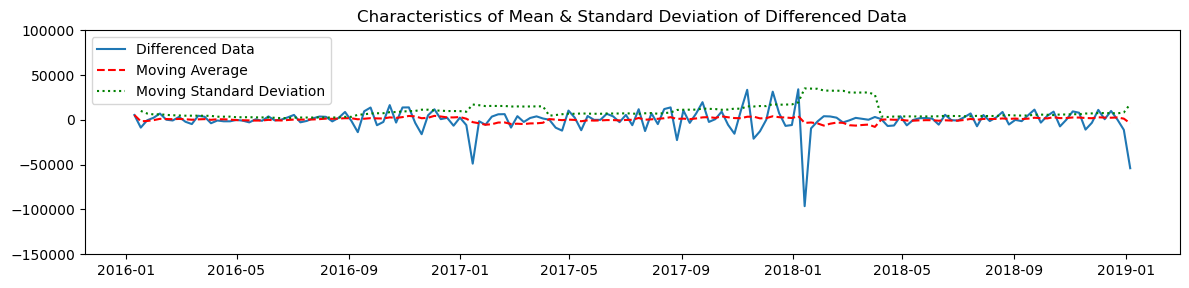

In [108]:
# Take the first difference to remove any trend component
pprofits_diff = pprofits.diff().dropna()


# Fit the rolling avg & std
pmove_avg = pprofits_diff.rolling(window=window_size, min_periods=1).mean()
pmove_std = pprofits_diff.rolling(window=window_size, min_periods=1).std()

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(pprofits_diff, label='Differenced Data')
plt.ylim(-150000, 100000)
plt.plot(pprofits_diff.index, pmove_avg, label='Moving Average', linestyle='dashed', color='red')
plt.plot(pprofits_diff.index, pmove_std, label='Moving Standard Deviation', linestyle='dotted', color='green')
plt.title('Characteristics of Mean & Standard Deviation of Differenced Data')
plt.tight_layout()
plt.legend()


In [ ]:
# Perform Adfuller ADF test for stationarity

# H0: has a unit root, non-stationary
# Ha: no unit root, is stationary (trend stationary)

adf_test1 = adfuller(pprofits_diff)

print('\nADF Statistic:', adf_test1[0])
print('p-value:', adf_test1[1], '\n')
print('Reject the null, data is stationary for weekly pink cab data\n ')



## Pink Cab Profit Forecast: Seasonal ARIMA

In [116]:
# Aggregate data
profit_series = mdf.groupby('company')['profit'].resample('W').sum()
profit_df = profit_series.unstack(level='company')

# Separate individual series for easier coding and identification
pprofits = profit_df['pink cab']


In [117]:
forecast1=None
del forecast1

transformer1=None
del transformer1

forecast=None
del forecast

transformer=None
del transformer

In [118]:
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer


# Create forecast object
forecast1 = Forecaster(
    current_dates = pprofits.index,
    y = pprofits,
    future_dates = 104,
)


In [ ]:
# Plot the ACF
forecast1.plot_acf()

In [ ]:
# Plot the PACF
forecast1.plot_pacf(method='ywm')

In [ ]:
forecast1.seasonal_decompose().plot()
plt.show()

In [119]:
# Create a transformer object
transformer1 = SeriesTransformer(forecast1)
forecast1 = transformer1.DiffTransform(52) 
forecast1 = transformer1.DetrendTransform()

<AxesSubplot: xlabel='Date', ylabel='Values'>

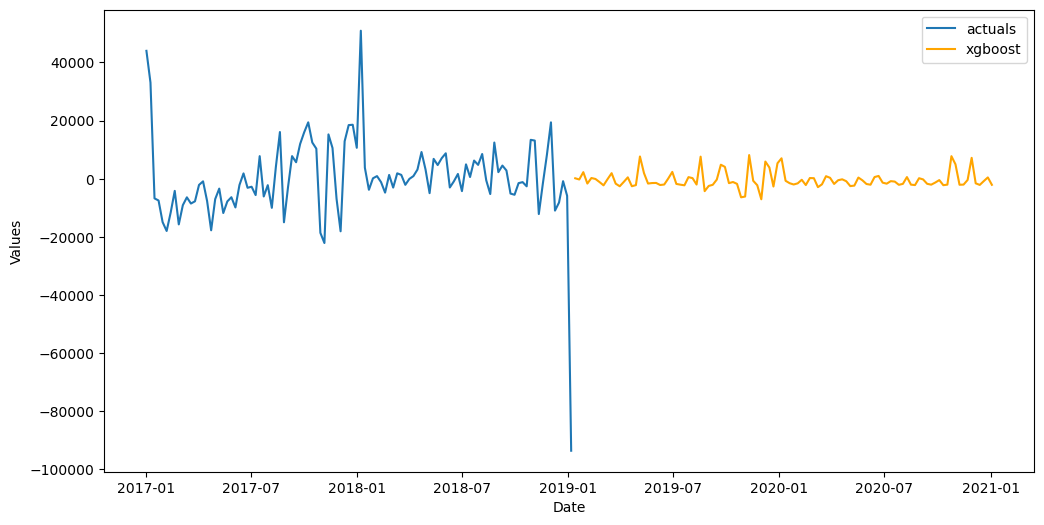

In [120]:
forecast1.set_estimator('xgboost')
forecast1.add_ar_terms(54)
forecast1.manual_forecast(n_estimators=100, gamma=2)
forecast1.plot()

In [121]:
forecast1 = transformer1.DetrendRevert()
forecast1 = transformer1.DiffRevert(52)


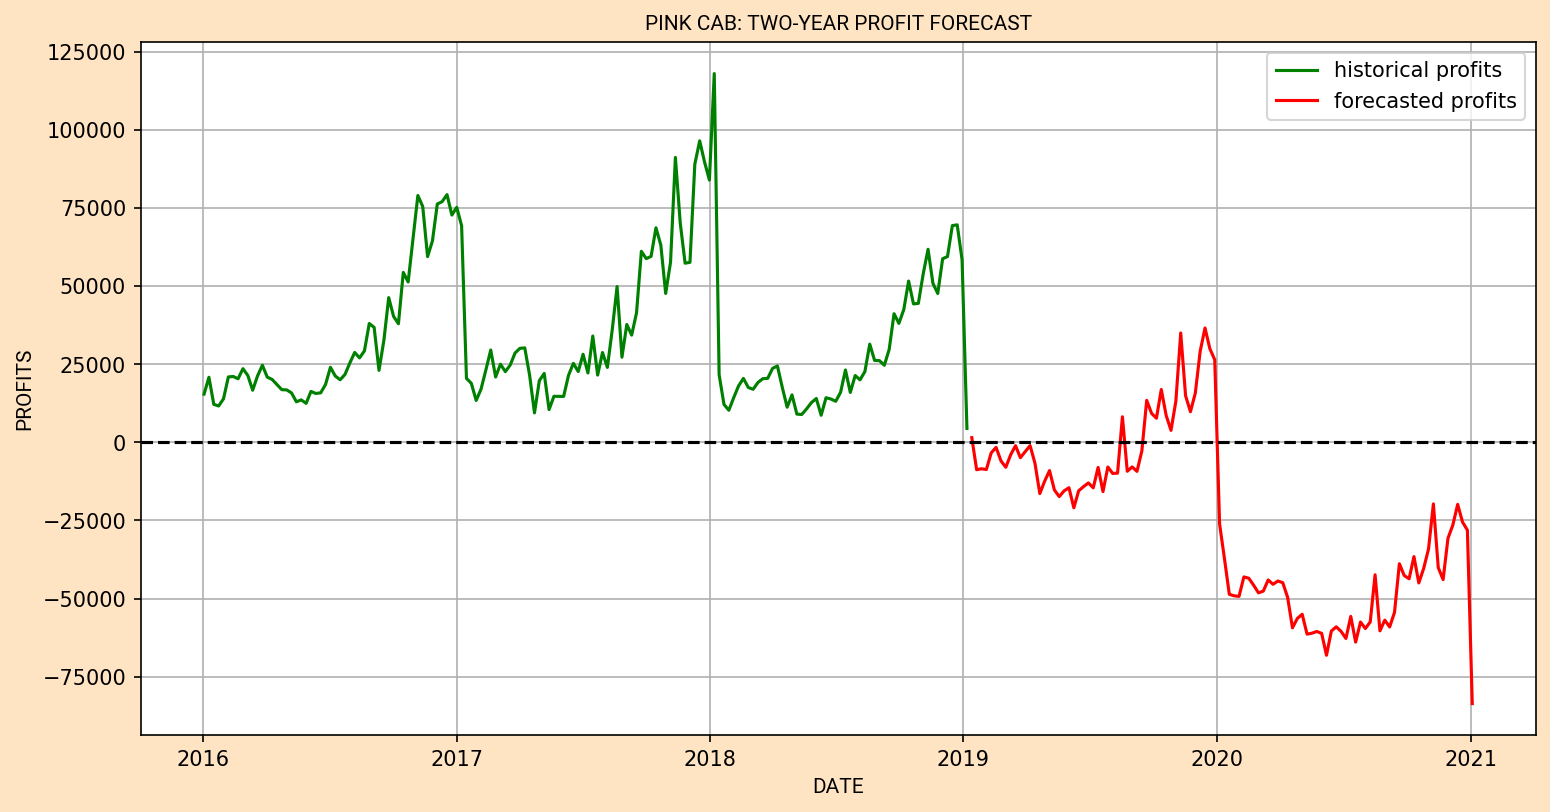

In [147]:
# pink: '#ff87a0'
# yellow: '#ffff66'

forecast1_plot = forecast1.plot()
forecast1_plot.set_title('PINK CAB: TWO-YEAR PROFIT FORECAST', fontsize=14, fontproperties=roboto)

# Set DPI (dots per inch)
forecast1_plot.get_figure().set_dpi(150)
forecast1_plot.get_figure().set_facecolor('bisque')


# Modify the size of the axis and figure
forecast1_plot.set_facecolor('white')  
forecast1_plot.set_xlabel('DATE', fontsize=10, fontproperties=roboto)
forecast1_plot.set_ylabel('PROFITS', fontsize=10, fontproperties=roboto)
forecast1_plot.grid(True)
legend = forecast1_plot.legend()

# Change handle names
for line, handle in zip(forecast1_plot.get_lines(), legend.legendHandles):
    if line.get_label() == 'actuals': 
        line.set_color('green')
        handle.set_color(line.get_color())
    elif line.get_label() == 'xgboost':
        line.set_color('red')
        handle.set_color(line.get_color())

# Plot the zero profit line
plt.axhline(y=0, linestyle='--', linewidth=1.5, color='black')

# Update the legend labels
new_labels = ['historical profits', 'forecasted profits']
for text, label in zip(legend.get_texts(), new_labels):
    text.set_text(label)
        
# Show the modified chart
plt.show()

# Save figure
forecast1_plot.get_figure().savefig('pink_forecast.png')

In [156]:
# COST TO COST RATIO: 

ycab['gender'].value_counts()/len(ycab['gender'])

male     0.58
female   0.42
Name: gender, dtype: float64

## Yellow Cab Stationarity: First Order & Seasonal Differencing, & ADF Test

In [ ]:
# Fit the rolling mean & standard deviations
ymove_avg = yprofits.rolling(window=window_size, min_periods=1).mean()
ymove_std = yprofits.rolling(window=window_size, min_periods=1).std()

In [ ]:

# Plot the moving averages
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(yprofits, label='Original Data')
plt.plot(yprofits.index, ymove_avg, label='Moving Average', linestyle='dashed', color='red')
plt.plot(yprofits.index, ymove_std, label='Moving Standard Deviation', linestyle='dotted', color='green')
plt.title('Characteristics of Mean & Standard Deviation of Data with Seasonal Component')
plt.tight_layout()
plt.legend()


In [ ]:
# Take the first difference of Yellow Cab data
yprofits_diff = yprofits.diff().dropna()

# Takd the 52-week seasonal difference to remove the seasonal component
yprofits_diff = yprofits_diff.diff(52).dropna()

# Fit the rolling avg & std
ymove_avg = yprofits_diff.rolling(window=window_size, min_periods=1).mean()
ymove_std = yprofits_diff.rolling(window=window_size, min_periods=1).std()

# Plot the moving averages and data
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(yprofits_diff, label='Differenced Data')
plt.ylim(-450000, 400000)
plt.plot(yprofits_diff.index, ymove_avg, label='Moving Average', linestyle='dashed', color='red')
plt.plot(yprofits_diff.index, ymove_std, label='Moving Standard Deviation', linestyle='dotted', color='green')
plt.title('Characteristics of Mean & Standard Deviation of Differenced Data')
plt.tight_layout()
plt.legend()


In [ ]:
# Perform Adfuller ADF test for stationarity

# H0: has a unit root, non-stationary
# Ha: no unit root, is stationary (trend stationary)

adf_test1 = adfuller(yprofits_diff)

print('\nADF Statistic:', adf_test1[0])
print('p-value:', adf_test1[1], '\n')
print('Reject the null, data is stationary for weekly yellow cab data\n ')


## Yellow Cab Profit Forecast: Seasonal ARIMA 

In [ ]:
# Aggregate data
profit_series = mdf.groupby('company')['profit'].resample('W').sum()
profit_df = profit_series.unstack(level='company')

# Separate individual series for easier coding and identification
yprofits = profit_df['yellow cab']


In [ ]:
forecast2=None
del forecast2

transformer2=None
del transformer2

In [ ]:
# Get familiar with the attributes of forecast object
dir(forecast2)

In [ ]:
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer


# Create forecast object
forecast2 = Forecaster(
    current_dates = yprofits_trdata.index,
    y = yprofits_trdata,
    future_dates = 104,
)


In [ ]:
# Plot the ACF
forecast2.plot_acf()

In [ ]:
# Plot the PACF
forecast2.plot_pacf(method='ywm')

In [ ]:
# Plot seasonal decomposition using Scalecast libray to confirm the TSA library results

forecast2.seasonal_decompose().plot()
plt.show()

In [ ]:
# Create a transformer object
transformer2 = SeriesTransformer(forecast2)

# Take the seasonal difference to rid data of seasonality
forecast2 = transformer2.DiffTransform(52) 

# Detrend the data
forecast2 = transformer2.DetrendTransform()

In [ ]:
# Set the algorithm we will use to make a prediction
forecast2.set_estimator('xgboost')

# Set the number of auto-regressive terms
forecast2.add_ar_terms(52)

# Perform the forecast
forecast2.manual_forecast(n_estimators=100, gamma=2)


In [ ]:

# Revert the detrending (must be first[opposite order])
forecast2 = transformer2.DetrendRevert()

# Revert the difference to get return the seasonality
forecast2 = transformer2.DiffRevert(52)


In [ ]:
# Plot original data plut the forecast
forecast2.seasonal_decompose().plot()

In [ ]:

# Configure plot of forecast
forecast2_plot = forecast2.plot()
forecast2_plot.get_figure().get_figure().set_dpi(150)
forecast2_plot.set(xlabel='Date', ylabel='Profits', title='Two Year Forecast of Profits')
forecast2_plot.set_facecolor('whitesmoke')  
forecast2_plot.grid(True)

# Configure legend
legend = forecast2_plot.legend()

# Change the color of profit lines
for line, handle in zip(forecast2_plot.get_lines(), legend.legendHandles):
    if line.get_label() == 'actuals':
        line.set_color('green')
        handle.set_color(line.get_color())
    elif line.get_label() == 'xgboost':
        line.set_color('red')
        handle.set_color(line.get_color())
        
# Update the legend labels
new_labels = ['historical profits', 'forecasted profits']
for text, label in zip(legend.get_texts(), new_labels):
    text.set_text(label)


    
# Show the modified chart
plt.show()

# Revenue

In [ ]:
from matplotlib.ticker import FuncFormatter

def format_plot(fig, ax, ylab, title):
    
    custom_ticks = [1e5, 1e6, 2e6, 1e7, 13e7]
    custom_labels = ['100k', '$1M', '$2M', '$10M', '$13M']


    # Apply the custom tick formatting function to major ticks on the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    
    # Apply the custom tick formatting function to minor ticks on the y-axis
    plt.gca().yaxis.set_minor_formatter(FuncFormatter(format_y_minorticks))
    
    # Set font size for both major and minor tick labels
    ax.tick_params(axis='y', labelsize=5, which='both', direction='inout')  
    
    # Set font size
    # plt.yticks(fontsize=7)

    # Set labels and title
    ax.set_ylabel(f'{ylab}', fontproperties=roboto, fontsize=5)
    ax.set_title(f'{title}', fontproperties=roboto, fontsize=7)

    # Add legend
    ax.legend(bbox_to_anchor=(1, 1.2), prop={'size': 5}, facecolor='whitesmoke')
    

    # Set ax facecolor
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')

    # Set figure facecolor
    fig.set_facecolor('bisque')

    # Set linewidth of spines
    ax.spines['top'].set_linewidth(.5)
    ax.spines['right'].set_linewidth(.5)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(.5)

    # Display the plot
    plt.tight_layout()
    
    # Turn on the grid lines for both major and minor ticks on the y-axis
    ax.yaxis.grid(which='both', linestyle='--', linewidth=0.1, color='black', alpha=1)

    # Adjust the whitespace around the axes
    #plt.subplots_adjust(left=0.1, right=1, bottom=0.7, top=0.9)

    
    plt.tight_layout()
    plt.show()

In [ ]:
# Create a custome y-tick formatter
def format_y_ticks(value, pos):
    custom_majorticks = [1e5, 1e6, 1e7, 2e7]
    custom_major_labels = ['100k', '$1M','$10M', '$20M']
    
    if value in custom_majorticks:
        return custom_major_labels[custom_majorticks.index(value)]
    
    return f"${value:.0f}"


def format_y_minorticks(value, pos):
    
    custom_majorticks = [1e5, 1e6, 1e7, 2e7, 3e7, 4e7]
    custom_minorticks = [2e6, 3e6, 4e6, 13e7]  
    custom_major_labels = ['100k', '$1M','$10M', '$20M', '$30M', '$40M']
    custom_minor_labels = ['$2M', '$3M', '$4M', '$13M']

    if value in custom_majorticks:
        return custom_major_labels[custom_majorticks.index(value)]

    if value in custom_minorticks:
        return custom_minor_labels[custom_minorticks.index(value)]

    return ""

In [ ]:
# Function that plots grouped bar charts
def plot_bars(df, fig, ax, companies, level1, level2, barwidth):
    colors = ['pink', 'yellow']
    # Plot bars for each company
    width = barwidth  
    for i, company in enumerate(companies):
        grp_revenue_company = df.xs(company, level='company')
        x = range(len(grp_revenue_company))
        x_shifted = [val + i * width for val in x]
        # Adjust the plot_bars function
        ax.bar(x_shifted, grp_revenue_company[level1], width=width, label=company, log=True,  # Set log to False
        zorder=4, color=colors[i], edgecolor='black', linewidth=.3, alpha=1)

    # Set x-axis labels and ticks
    ax.set_xticks([val + width * (len(companies) - 1) / 2 for val in x])
    ax.set_xticklabels(grp_revenue_company.index.get_level_values(level2), rotation=45, ha='right', fontproperties=roboto,
                       fontsize=6)

## Revenues By State

In [ ]:
# Group data according to company by state
state_revenue = mdf.groupby(['company', 'city']).agg({'cost':'sum'})

# Extract unique companies for legend
companies = state_revenue.index.get_level_values('company').unique()

# Create a figure and axis
fig1, ax1 = plt.subplots(figsize=(4, 3), dpi=150)

# Plot bars
plot_bars(state_revenue, fig1, ax1, companies, 'cost', 'city', 0.3)

# Format plot
format_plot(fig1, ax1, 'COST', 'COSTS BY CITY')

# save
fig1.savefig('city_costs.png', dpi=300, bbox_inches='tight')


## Revenues By City

In [ ]:

# Group data according to company by city
city_revenue = mdf.groupby(['city', 'company']).agg({'price':'sum'})

# Extract unique companies for legend
companies = city_revenue.index.get_level_values('company').unique()

# Create a figure and axis
fig2, ax2 = plt.subplots(figsize=(6, 3), dpi=150)

# Plot bars
plot_bars(city_revenue, fig2, ax2, companies, 'city', 0.3)

# Format plot
format_plot(fig2, ax2, 'City')

# Change 'ax' linewidth
ax2.spines['top'].set_linewidth(0.1)


In [197]:

colorz = ['#6b4469', '#cdbef6', '#de5a64', '#96defb', '#5daf34', '#437a70', '#1adeef', '#c6731d',
          '#ff8797', '#044d10', '#aa3885', '#a1dddb', '#3b6021', '#b3274f', '#14373c', '#68ddf0',
          '#25c364', '#48bb7a', '#8fd45b', '#c2deb9', '#ca5f53', '#71b811', '#ebc0d9', '#4e7bdc',
          '#7afa0a', '#87698c', '#f7ce7b', '#b2d8e7', '#f18639', '#20b3a4', '#f4a8f8', '#9d532e',
          '#9e7f8e', '#1c898e', '#f9f76d', '#ce1e46', '#a4db3a', '#c67e7c', '#55decd', '#a6ac6a',
          '#285537', '#e6bbaa', '#478ab5', '#5c238b', '#4975cc', '#8f860e', '#d30a5d', '#779ab5']


# Create a crosstab function to explore categorical data

def visualize(data, feature, target, colors):
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(40,20), dpi=150)
    
    # Plot the graph
    crosstab_result = pd.crosstab(data[feature], data[target], normalize=0)
    crosstab_result = crosstab_result.fillna(0)
    
    graph = crosstab_result.plot(
        kind='bar', ax=ax, color=colors, width=.5, align='center', edgecolor='black', linewidth=.8, zorder=4)
    print(crosstab_result)
    # Add vertical lines between groups of brands
    for i in range(len(crosstab_result)):
        if i > 0:
            ax.axvline(x=i - 0.5, color='gray', linewidth=4, linestyle='--')
    
    # Adjust the spacing around the chart
    plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
    
    # Adjust the size of the left y-axis tick labels
    ax.tick_params(axis='y', labelsize=25)
    ax.tick_params(axis='x', labelsize=25)
    
    # Adjust the left margin of the plot
    plt.margins(0.1)
    
    # Adjust the lineweights of the ax spines
    spines = ['left', 'top', 'right', 'bottom']
    for spine in spines:
        ax.spines[spine].set_linewidth(3)
    
    # Create a color dictionary
    color_dict = {label: colors[i % len(colors)] for i, label in enumerate(data[target].unique())}
 
    # This is debugging code: reverse the values of the color_dict
    key1_value = color_dict['male']
    key2_value = color_dict['female']

    color_dict['male'] = key2_value
    color_dict['female'] = key1_value

    # Configure and style the legend
    legend_labels = data[target].unique()
    legend_handles = [Patch(facecolor=color_dict[label], label=label) for label in legend_labels]
    plt.legend(
        handles=legend_handles,
        bbox_to_anchor=(0.5, 1.20),
        loc='upper center',
        ncol=13,
        borderaxespad=0.,
        borderpad=.5,
        prop={'size': 35}
    )
    
    # Set the x-axis label, and y-axis label
    ax.set_facecolor('whitesmoke')
    plt.xticks(rotation=-360, fontsize=40)
    plt.yticks(fontsize=50)
    plt.xlabel('COMPANY', fontsize=50, labelpad=30)
    plt.ylabel('% of FARES', fontsize=50, labelpad=20)
    plt.title(f'FARE FREQUENCY BY {target.upper()}', fontsize=60, pad=30)
    
    plt.tight_layout()  # Automatically adjust the layout
    plt.grid(True)
    plt.show()

    return crosstab_result, fig, ax



In [ ]:
# Set color scheme for the visualize() function

colorz = ['#6b4469', '#cdbef6', '#de5a64', '#96defb', '#5daf34', '#437a70', '#1adeef', '#c6731d',
          '#ff8797', '#044d10', '#aa3885', '#a1dddb', '#3b6021', '#b3274f', '#14373c', '#68ddf0',
          '#25c364', '#48bb7a', '#8fd45b', '#c2deb9', '#ca5f53', '#71b811', '#ebc0d9', '#4e7bdc',
          '#7afa0a', '#87698c', '#f7ce7b', '#b2d8e7', '#f18639', '#20b3a4', '#f4a8f8', '#9d532e',
          '#9e7f8e', '#1c898e', '#f9f76d', '#ce1e46', '#a4db3a', '#c67e7c', '#55decd', '#a6ac6a',
          '#285537', '#e6bbaa', '#478ab5', '#5c238b', '#4975cc', '#8f860e', '#d30a5d', '#779ab5']


gender      female  male
company                 
pink cab      0.44  0.56
yellow cab    0.42  0.58


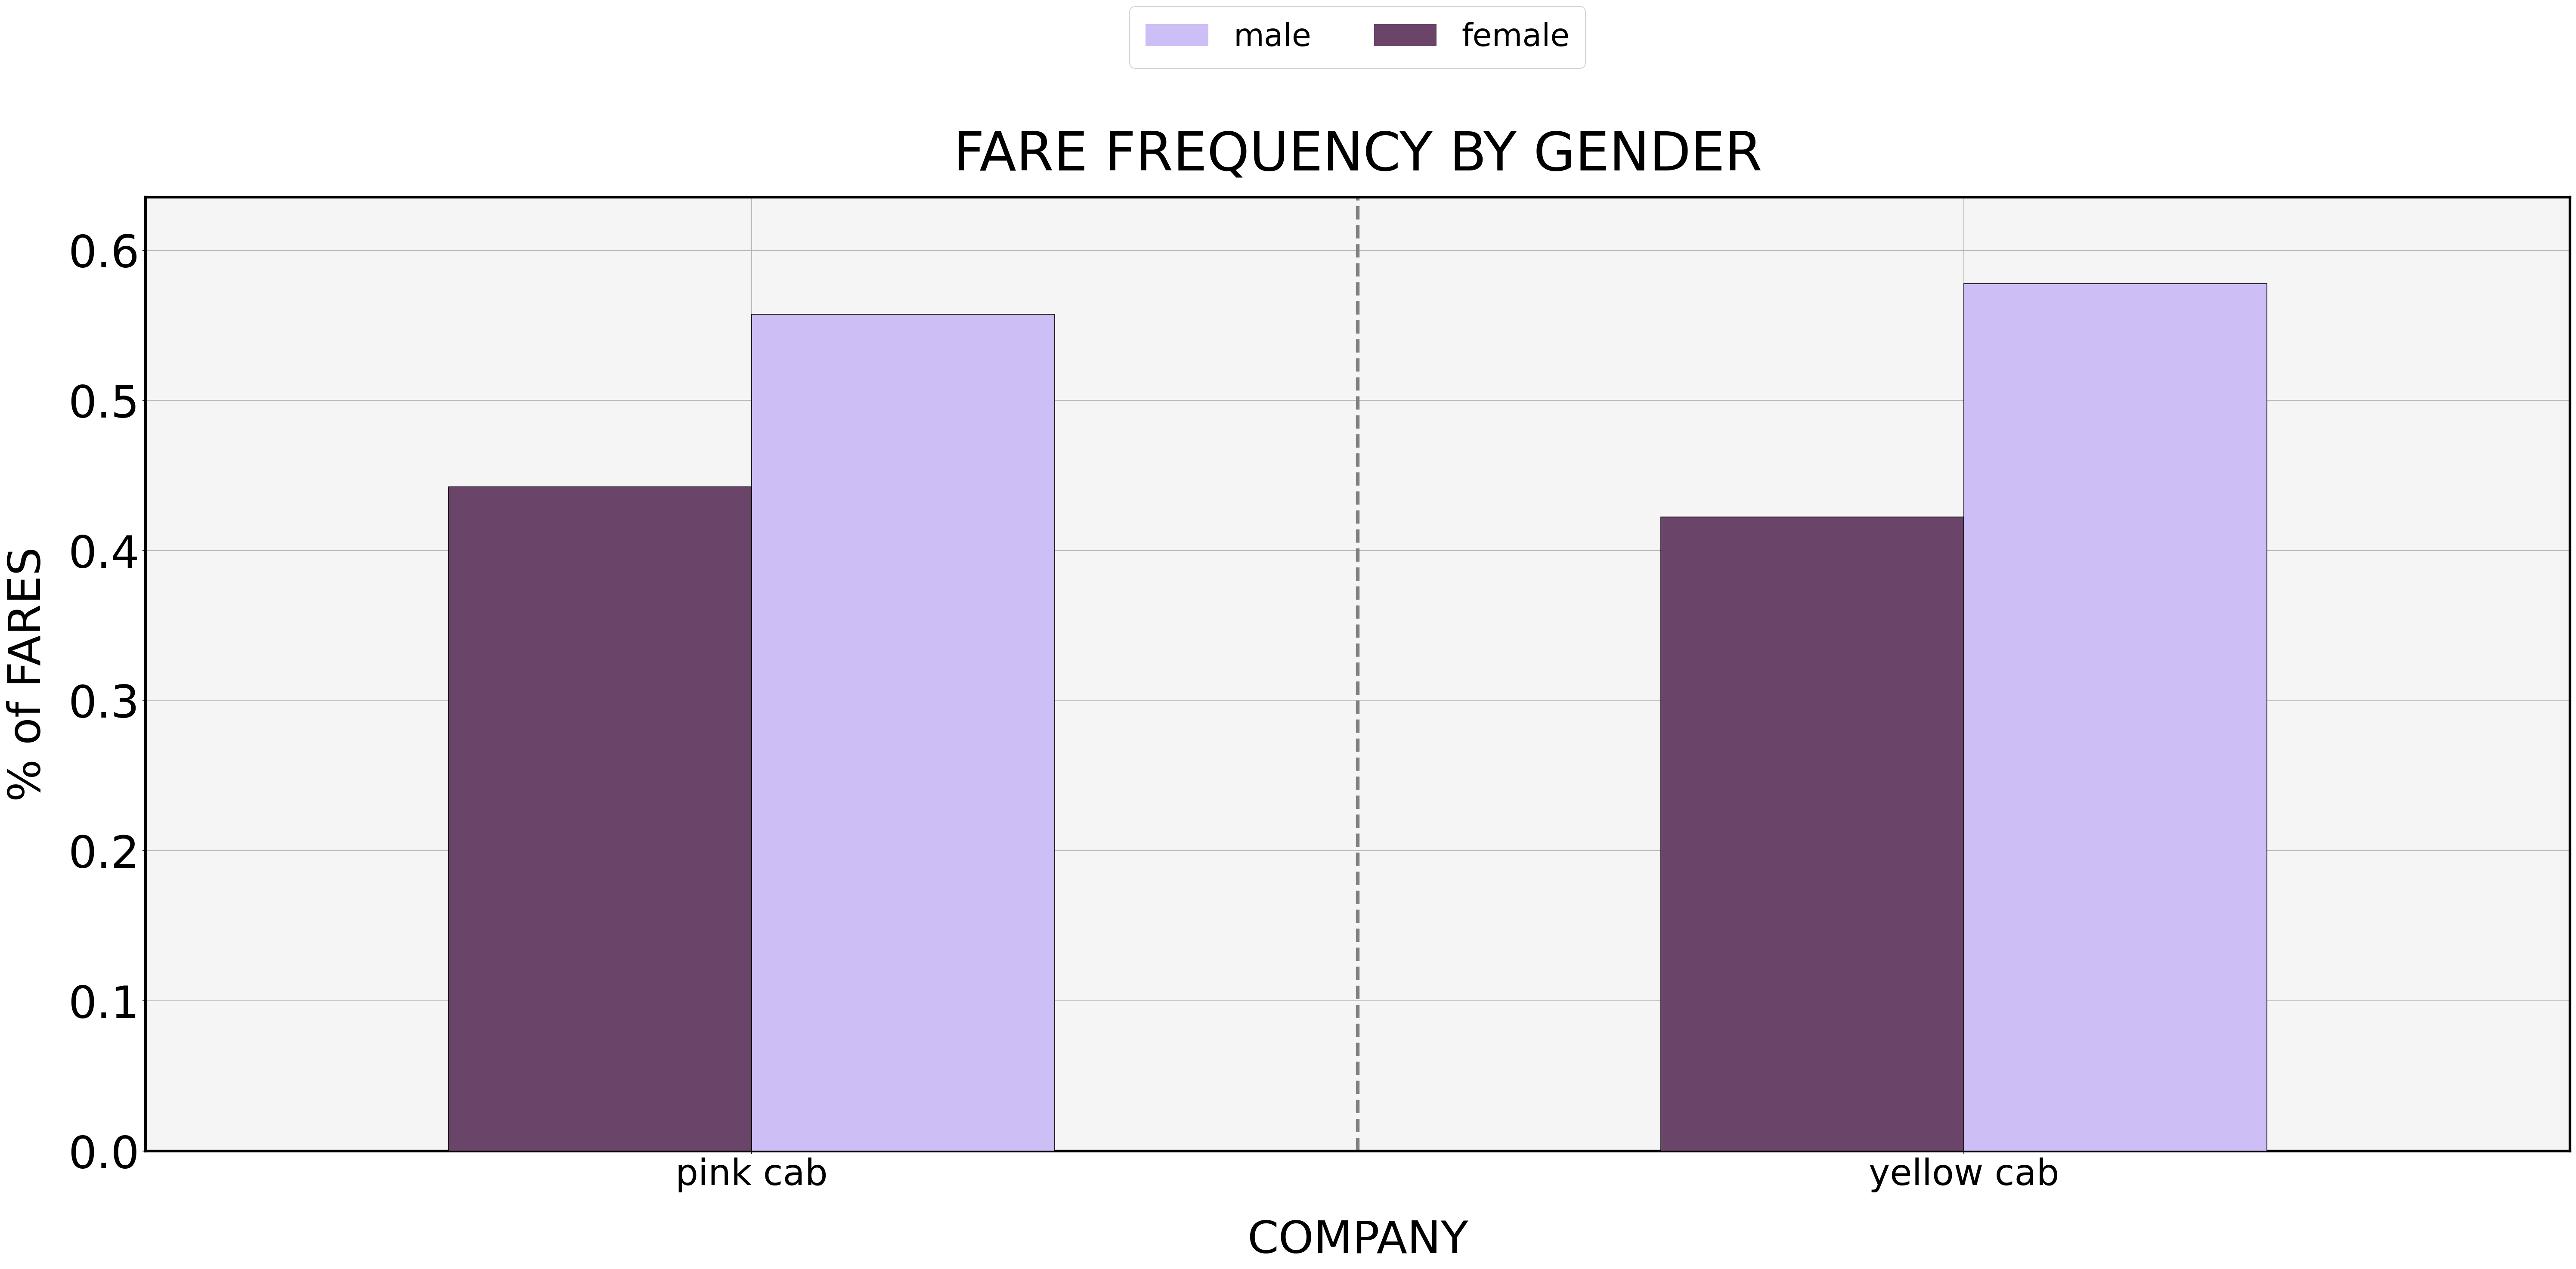

In [198]:
result, fig5, ax5 = visualize(mdf, 'company', 'gender', colorz)
fig5.savefig('gender_frequency.png')

In [ ]:
visualize(mdf, 'company', 'age', colorz)

In [ ]:
visualize(mdf, 'company', 'payment_type', colorz)

In [ ]:
visualize(mdf, 'company', 'state', colorz)

In [ ]:
crosstab_result = visualize(mdf, 'company', 'city', colorz)
crosstab_result

In [ ]:
# Transpose the 'ctab_results'
ctab = crosstab_result.T.reset_index()

# Merge the two DataFrames on the 'city' column
cdf = pd.merge(cdf, ctab, on='city')

# Create index 20 
cdf.loc[20] = ['san francisco', 629591, 213609, 0.34, 'ca', 0.00, 0.00]

# Sort by city
cdf.sort_values(by='city', inplace=True)

# Display
cdf

In [ ]:
#Create a mapper
newcdf_names = {'% of users':'% of users in pop','pink cab':'pink mkt share', 'yellow cab':'yellow mkt share'}

# Rename columns
cdf.rename(newcdf_names, axis=1, inplace=True)

# Create a total column
cdf['total mkt share'] = cdf['pink mkt share'] + cdf['yellow mkt share']

# Display
cdf

## MrktShare & Profit Growth Rates: Yellow & Pink Cab Companies

In [ ]:
def format_plot(data, fig, ax, xlab, ylab, title, axis='y'):
    
    # Define the custom y-axis tick locations and labels in data units
    custom_ticks = [1e6, 2e6, 10e6]
    custom_labels = ['$1M', '$2M', '$10M']

    # Within the format_plot function
    ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

    # Set font size
    plt.yticks(fontsize=5)

    # Set labels and title
    ax.set_xlabel(xlab, fontproperties=roboto, fontsize=7)
    ax.set_ylabel(ylab, fontproperties=roboto, fontsize=7)
    ax.set_title(f'{title}', fontproperties=roboto, fontsize=9)
    
    # Set tick parameters
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)

    # Set spine parameters
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.spines['top'].set_linewidth(.3)
    ax.spines['right'].set_linewidth(.3)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1, 1), prop={'size': 7})

    # Set ax facecolor
    #ax = plt.gca()
    fig.set_facecolor('whitesmoke')

    # Set the color of the plot perimeter (spines)
    perimeter_color = 'black'  
    ax.spines['top'].set_color(perimeter_color)
    ax.spines['right'].set_color(perimeter_color)
    ax.spines['bottom'].set_color(perimeter_color)
    ax.spines['left'].set_color(perimeter_color)

    # Display the plot
    plt.tight_layout()
    plt.grid(True, linewidth=.5, color='black', axis=axis)
    plt.tight_layout()
  

In [ ]:
# Group the data
qrtrly_mrkt_share = mdf.groupby(['city', 'quarters', 'company'])['price'].sum() / mdf.groupby(['city', 'quarters'])['price'].sum()

# Create df to store the quarterly market share data for each city
cdf = qrtrly_mrkt_share.unstack(level='company').reset_index()

# Step 3: Calculate growth rates for each city and each cab company
cdf['pink growth_rate'] = cdf.groupby('city')['pink cab'].pct_change()
cdf['yellow growth_rate'] = cdf.groupby('city')['yellow cab'].pct_change()


# ## Visualize the quarter growth rates

fig13, ax13 = plt.subplots(figsize=(10, 5), dpi=150)

# Plot growth rates for pink cab
for i, (city, data) in enumerate(cdf.groupby('city')):
    plt.plot(data['quarters'], data['pink growth_rate'], label=city, marker='o', color=colorz[i], markeredgecolor='black')

format_plot(cdf, fig13, ax13, '', 'Quarterly Growth Rate', 'COMPARATIVE CITY MARKETSHARE GROWTH: Pink Cab Co.', 
            axis='both')


# # Plot growth rates for yellow cab

fig14, ax14 = plt.subplots(figsize=(10, 5), dpi=150)

for i, (city, data) in enumerate(cdf.groupby('city')):
    plt.plot(data['quarters'], data['yellow growth_rate'], label=city, marker='o', color=colorz[i], markeredgecolor='black')

format_plot(cdf, fig14, ax14, '', 'Quarterly Growth Rate', 'COMPARATIVE CITY QUARTERLY MARKETSHARE GROWTH: Yellow Cab Co.',
            axis='both')



In [ ]:
# Group the data
qrtrly_mrkt_share = mdf.groupby(['city', 'quarters', 'company'], dropna=True)['profit'].sum() / mdf.groupby(['city', 'quarters'])['profit'].sum()

# Create df to store the quarterly market share data for each city
mrkt_share_df = qrtrly_mrkt_share.unstack(level='company').reset_index()

# Step 3: Calculate growth rates for each city and each cab company
mrkt_share_df['pink growth_rate'] = mrkt_share_df.groupby('city', dropna=True)['pink cab'].pct_change()
mrkt_share_df['yellow growth_rate'] = mrkt_share_df.groupby('city', dropna=True)['yellow cab'].pct_change()

# Drop 'nan', and extreme outlier
mrkt_share_df.drop(0, axis=0, inplace=True)
mrkt_share_df.drop(62, axis=0, inplace=True)

## Visualize the quarter growth rates
fig15, ax15 = plt.subplots(figsize=(10, 5), dpi=150)

for i, (city, data) in enumerate(mrkt_share_df.groupby('city')):
    plt.plot(data['quarters'], data['pink growth_rate'], label=city, marker='o', color=colorz[i], markeredgecolor='black')
format_plot(mrkt_share_df, fig15, ax15, '', 'Quarterly Profit Growth', 'COMPARATIVE CITY PROFIT GROWTH: Pink Cab Co.',
            axis='both')

# Plot growth rates for yellow cab
fig16, ax16 = plt.subplots(figsize=(10, 5), dpi=150)

for i, (city, data) in enumerate(mrkt_share_df.groupby('city')):
    plt.plot(data['quarters'], data['yellow growth_rate'], label=city, marker='o', color=colorz[i], markeredgecolor='black')
format_plot(mrkt_share_df, fig16, ax16, '', 'Quarterly Profit Growth', 'COMPARATIVE CITY PROFIT GROWTH: Yellow Cab Co.', 
            axis='both')







In [ ]:
# Group the data
qrtrly_mrkt_share = mdf.groupby(['state', 'quarters', 'company'])['price'].sum() / mdf.groupby(['state', 'quarters'])['price'].sum()

# Create df to store the quarterly market share data for each city
mrkt_share_df = qrtrly_mrkt_share.unstack(level='company').reset_index()

# Step 3: Calculate growth rates for each city and each cab company
mrkt_share_df['pink growth_rate'] = mrkt_share_df.groupby('state')['pink cab'].pct_change()
mrkt_share_df['yellow growth_rate'] = mrkt_share_df.groupby('state')['yellow cab'].pct_change()


## Visualize the quarter growth rates

fig16, ax16 = plt.subplots(figsize=(10, 5), dpi=150)

for i, (city, data) in enumerate(mrkt_share_df.groupby('state')):
    plt.plot(data['quarters'], data['pink growth_rate'], label=city, marker='o', color=colorz[i], markeredgecolor='black')
format_plot(mrkt_share_df, fig16, ax16, '', 'Quarterly Profit Growth', 'COMPARATIVE STATE MARKETSHARE GROWTH: Pink Cab Co.',
            axis='both')


fig17, ax17 = plt.subplots(figsize=(10, 5), dpi=150)

for i, (city, data) in enumerate(mrkt_share_df.groupby('state')):
    plt.plot(data['quarters'], data['yellow growth_rate'], label=city, marker='o', color=colorz[i], markeredgecolor='black')
format_plot(mrkt_share_df, fig17, ax17, '', 'Quarterly MrktShare Growth', 'COMPARATIVE STATE MARKETSHARE GROWTH: Yellow Cab Co.',
            axis='both')

In [ ]:
# Group the data
qrtrly_mrkt_share = mdf.groupby(['state', 'quarters', 'company'])['profit'].sum() / mdf.groupby(['state', 'quarters'])['profit'].sum()

# Create df to store the quarterly market share data for each city
mrkt_share_df = qrtrly_mrkt_share.unstack(level='company').reset_index()

# Step 3: Calculate growth rates for each city and each cab company
mrkt_share_df['pink growth_rate'] = mrkt_share_df.groupby('state')['pink cab'].pct_change()
mrkt_share_df['yellow growth_rate'] = mrkt_share_df.groupby('state')['yellow cab'].pct_change()

# Drop 'nan', and extreme outlier
mrkt_share_df.drop(0, axis=0, inplace=True)
mrkt_share_df.drop(26, axis=0, inplace=True)

## Visualize the quarter growth rates
fig18, ax18 = plt.subplots(figsize=(10, 5), dpi=150)

for i, (city, data) in enumerate(mrkt_share_df.groupby('state')):
    plt.plot(data['quarters'], data['pink growth_rate'], label=city, marker='o', color=colorz[i], markeredgecolor='black')
format_plot(mrkt_share_df, fig18, ax18, '', 'Quarterly Profit Growth', 'COMPARATIVE STATE PROFIT GROWTH: Pink Cab Co.',
            axis='both')


fig19, ax19 = plt.subplots(figsize=(10, 5), dpi=150)

for i, (city, data) in enumerate(mrkt_share_df.groupby('state')):
    plt.plot(data['quarters'], data['yellow growth_rate'], label=city, marker='o', color=colorz[i], markeredgecolor='black')
format_plot(mrkt_share_df, fig19, ax19, '', 'Quarterly Profit Growth', 'COMPARATIVE STATE PROFIT GROWTH: Yellow Cab Co.',
            axis='both')


In [ ]:
# Results: Each company has it strengths and weakneses. However, I would recommend not to buy pink cab, 
# and be cautious with buying Yellow cab. While histoically Yellow Cab
# Is performing much better than pink, an identical trend was discovered within both of Pink Cabs and Yellow Cabs 
# profit history, and then forecasted. In short, each successive yearly cycle is generating less profits. This can be seen with the three years
# of data that we have looked at thus far. To see if this trend is part of a larger trend. More years of data needs to be
# analyzed. If the current profit trend contiues it's course, both companies will be in the red by 2020. 
# XYZ should keep in mind that traditional cab companies profits, have been getting eaten up by rideshare companies like 
# Uber and Lyft over the past 5-10 years, and is what is most likely, in my opinion, the cause of the deacrease in profits.
# The trend that we see could be due to more users adopting to take Uber and Lyft instead of traditional cab companies. 
# Therefore, I recommend that XYZ, be cautious before buying Yellow cab, while simultaneously looking at potential 
# oppurtunities to run a fleet of rideshare vehicles.

## The supporting evidence will be showcased during the presentation. Thank you. 

In [ ]:
mdf.head()

In [ ]:
# Function that plots grouped bar charts
def plot_bars(df, fig, ax, companies, level, barwidth):
    colors = ['pink', 'yellow']
    # Plot bars for each company
    width = barwidth  
    for i, company in enumerate(companies):
        grp_revenue_company = df.xs(company, level='company')
        x = range(len(grp_revenue_company))
        x_shifted = [val + i * width for val in x]
        ax.bar(x_shifted, grp_revenue_company['profit'], width=width, label=company, log=True, 
               zorder=4, color=colors[i], edgecolor='black', linewidth=.3, alpha=1)

    # Set x-axis labels and ticks
    ax.set_xticks([val + width * (len(companies) - 1) / 2 for val in x])
    ax.set_xticklabels(grp_revenue_company.index.get_level_values(level), rotation=45, ha='right', fontproperties=roboto,
                          fontsize=6)

In [ ]:
ycab = mdf[mdf['company'] == 'yellow cab']
pcab = mdf[mdf['company'] == 'pink cab']

pcabqprofits = mdf.groupby(['year', 'company']).agg({'profit': 'sum'})



# Extract unique companies for legend
companies = pcabqprofits.index.get_level_values('company').unique()


# Create the plot
fig20, ax20 = plt.subplots(figsize=(8, 4), dpi=150)
plot_bars(pcabqprofits, fig20, ax20, companies, 'year', 0.3)
format_plot(pcabqprofits, fig20, ax20, '', 'PROFITS', 'YEARLY PROFITS')

ax20.set_facecolor('whitesmoke')

fig20.set_facecolor('bisque')
ax20.spines['left'].set_linewidth(1)
ax20.spines['right'].set_linewidth(1)
ax20.spines['top'].set_linewidth(1)
plt.ylabel('PROFITS', fontsize=8, fontproperties=roboto)
plt.xticks(rotation=45)  
plt.show()



In [ ]:
# ANOVA for difference in profits and cash card

In [ ]:
cash_card = mdf.groupby(['company', 'payment_type']).agg({'profit': 'sum'})

# Pivot the DataFrame to get company and payment type as columns
cash_card = cash_card.pivot_table(index='payment_type', columns='company', values='profit')

# Create the bar chart

colors = {'pink cab': 'pink', 'yellow cab': 'yellow'}

fig21 = cash_card.plot(kind='bar', figsize=(8, 4), color=[colors[col] for col in cash_card.columns], 
                     edgecolor='black', linewidth=.3, zorder=4, width=.3)
fig21.get_figure().set_dpi(150)

# Access the Axes object from the figure
ax20 = fig.axes

ax21.set_xlabel('Payment Type', fontproperties=roboto, fontsize=8)
ax21.set_ylabel('Profit', fontproperties=roboto, fontsize=8)
ax21.set_title('Profit by Company and Payment Type', fontproperties=roboto, fontsize=10)
ax21.set_facecolor('whitesmoke')
ax21.set_xticklabels(['card', 'cash'], fontsize=5, fontproperties=roboto, rotation=45)

y_ticks = [0, 5e6, 10e6, 15e6, 20e6, 25e6]
y_tick_labels = ['0', '5M', '10M', '15M', '20M', '25M']
ax21.set_yticks(y_ticks)
ax21.set_yticklabels(y_tick_labels, fontproperties=roboto, fontsize=5)


ax21.spines['top'].set_linewidth(0.5)
ax21.spines['right'].set_linewidth(1)
ax21.spines['left'].set_linewidth(1)
ax21.spines['bottom'].set_linewidth(0.5)
ax21.legend(fontsize=8)
ax21.grid(True, linewidth=.3, axis='y')

plt.show()  # Display the plot






plt.tight_layout()
plt.show()









## What do Profits Depend On?

In [ ]:
dfs()

In [ ]:
cont_features.append('profit_margin')

In [ ]:
pcab['profit_margin'] = pcab['profit']/pcab['price']
ycab['profit_margin'] = ycab['profit']/ycab['price']

In [ ]:
corr_matrix1 = pcab[cont_features].corr()
corr_matrix


corr_matrix2 = ycab[cont_features].corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot of Pink Cab Numerical Data')
plt.show()

plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot of Yellow Cab Numerical Data')
plt.show()

In [ ]:
cont_features

In [190]:
pcab = mdf[mdf['company'] == 'pink cab']
ycab = mdf[mdf['company'] == 'yellow cab']

day_of_week
sunday      77.74
monday      47.29
tuesday     47.89
wednesday   47.62
thursday    47.07
friday      69.26
saturday    67.69
Name: profit, dtype: float64
day_of_week
sunday      181.26
monday      139.72
tuesday     139.57
wednesday   137.95
thursday    137.13
friday      169.74
saturday    167.43
Name: profit, dtype: float64


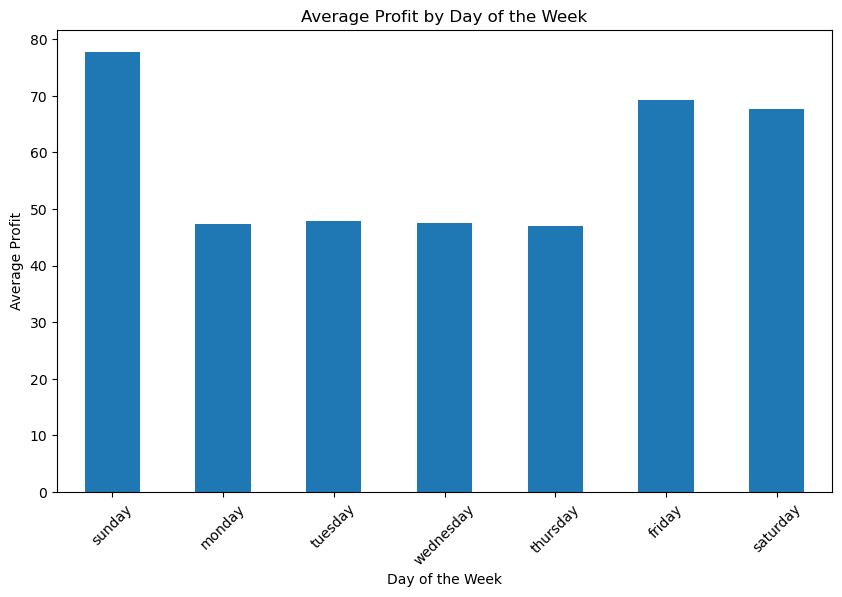

TypeError: format_plot() missing 6 required positional arguments: 'data', 'fig', 'ax', 'xlab', 'ylab', and 'title'

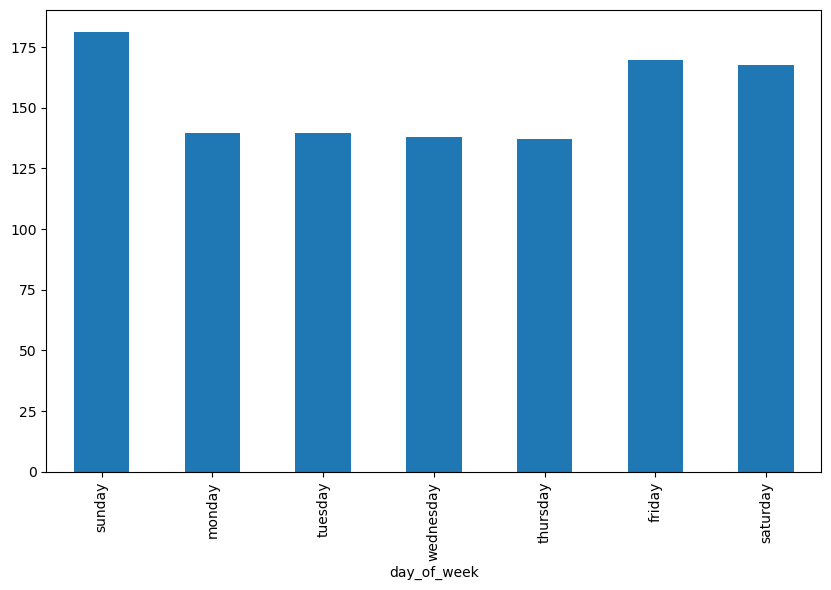

In [191]:
paverage_profits_by_day = pcab.groupby('day_of_week')['profit'].mean()
print(paverage_profits_by_day)

yaverage_profits_by_day = ycab.groupby('day_of_week')['profit'].mean()
print(yaverage_profits_by_day)

plt.figure(figsize=(10, 6))
paverage_profits_by_day.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Average Profit')
plt.title('Average Profit by Day of the Week')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
yaverage_profits_by_day.plot(kind='bar')
format_plot()
plt.xlabel('Day of the Week')
plt.ylabel('Average Profit')
plt.title('Average Profit by Day of the Week')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from statsmodels.formula.api import ols

# Create a model using ordinary least squares (OLS)
model = ols('profit ~ day_of_week', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['profit'], pcab['day_of_week'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
# Create a model using ordinary least squares (OLS)
model = ols('profit ~ day_of_week', data=ycab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(ycab['profit'], ycab['day_of_week'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
# Create a model using ordinary least squares (OLS)
model = ols('profit ~ gender', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['profit'], pcab['gender'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
# Create a model using ordinary least squares (OLS)
model = ols('profit ~ gender', data=ycab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(ycab['profit'], ycab['gender'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
paverage_profits_by_gender = pcab.groupby('gender')['profit'].mean()
print(paverage_profits_by_gender)

yaverage_profits_by_gender = ycab.groupby('gender')['profit'].mean()
print(yaverage_profits_by_gender)

plt.figure(figsize=(10, 6))
paverage_profits_by_gender.plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Average Profit')
plt.title('Average Profit by Gender')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
yaverage_profits_by_gender.plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Average Profit')
plt.title('Average Profit by Gender')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Create a model using ordinary least squares (OLS)
model = sm.ols('profit ~ age_category', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['profit'], pcab['age_category'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
# Create a model using ordinary least squares (OLS)
model = ols('profit ~ age_category', data=ycab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(ycab['profit'], ycab['age_category'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
paverage_profits_by_age = pcab.groupby('age_category')['profit'].mean()
print(paverage_profits_by_age)

yaverage_profits_by_age = ycab.groupby('age_category')['profit'].mean()
print(yaverage_profits_by_age)

plt.figure(figsize=(10, 6))
paverage_profits_by_age.plot(kind='bar')
plt.xlabel('Age Category')
plt.ylabel('Average Profit')
plt.title('Average Profit by Age Category')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
yaverage_profits_by_age.plot(kind='bar')
plt.xlabel('Age Category')
plt.ylabel('Average Profit')
plt.title('Average Profit by Age Category')
plt.xticks(rotation=45)
plt.show()

## Who Drives More Miles?

In [ ]:
pmiles = pcab['trip_miles'].sum()
ymiles = ycab['trip_miles'].sum()

print(f'Pink Cab drove: {pmiles} over the past 3 years')
print(f'Yellow Cab drove: {ymiles} over the past 3 years')

In [ ]:
ymiles/pmiles

In [ ]:
# Miles per quarter

pqmiles = pcab.groupby('year')['profit'].sum()
pqmiles

In [ ]:
yqmiles = ycab.groupby('year')['profit'].sum()
yqmiles

## Busiest Cities?

In [ ]:
pcitymiles = pcab.groupby('city')['profit'].sum()
pcitymiles

In [ ]:
ycity_by_day_profits = ycab.groupby(['city', 'day_of_week'])['profit'].mean()
ycity_by_day_profits


day_of_week
sunday      116.99
monday       87.74
tuesday      90.10
wednesday    71.01
thursday     92.23
friday      111.52
saturday    107.21
Name: profit, dtype: float64
day_of_week
sunday      141.15
monday      100.43
tuesday     101.71
wednesday   102.18
thursday    101.80
friday      130.61
saturday    128.93
Name: profit, dtype: float64
day_of_week
sunday      172.17
monday      117.84
tuesday     135.16
wednesday   126.65
thursday    123.80
friday      148.33
saturday    157.27
Name: profit, dtype: float64
day_of_week
sunday      98.96
monday      63.84
tuesday     64.30
wednesday   64.20
thursday    63.82
friday      92.64
saturday    86.97
Name: profit, dtype: float64
day_of_week
sunday      160.38
monday      110.25
tuesday     109.44
wednesday   119.48
thursday    109.26
friday      144.81
saturday    134.49
Name: profit, dtype: float64
day_of_week
sunday      143.86
monday      111.93
tuesday     111.87
wednesday   113.85
thursday    104.33
friday      139.78
saturday   

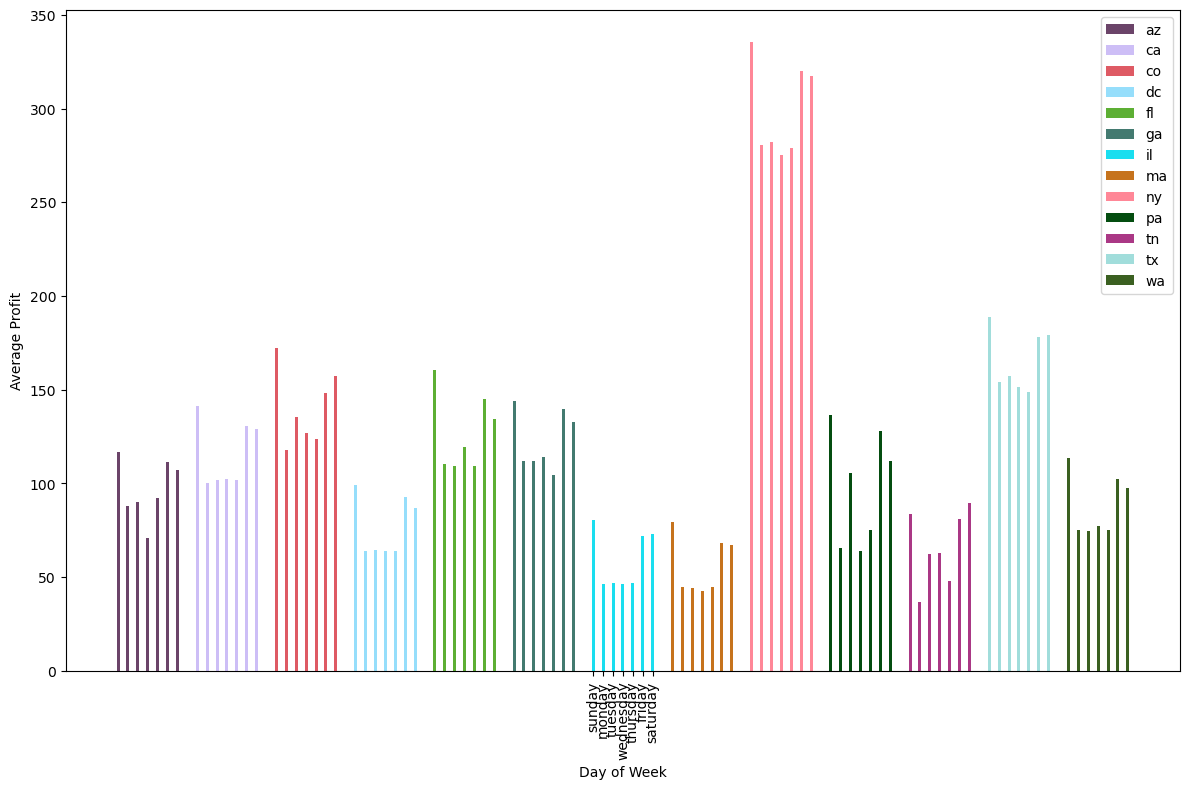

In [192]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace this with your actual data)
ystate_by_day_profits = ycab.groupby(['state', 'day_of_week'])['profit'].mean()

# Determine the number of states and days
num_states = len(ystate_by_day_profits.index.get_level_values('state').unique())
num_days = len(ystate_by_day_profits.index.get_level_values('day_of_week').unique())
width = 0.3  # Width of each bar

# Create a range for the x-axis
x = np.arange(num_days) + np.arange(num_states).reshape(-1, 1) * (num_days + 1)

# Create the figure and axis
fig22, ax22 = plt.subplots(figsize=(12, 8))

# Get unique states to iterate over
states = ystate_by_day_profits.index.get_level_values('state').unique()


# Set x-axis labels based on multi-index
x_labels = ystate_by_day_profits.index.get_level_values('day_of_week').unique()


# Plot the data with spacing between states
for i, state in enumerate(states):
    state_data = ystate_by_day_profits.loc[state]
    print(state_data)
    ax22.bar(x[i], state_data, width=width, label=state, color=colorz[i])
    ax22.set_xticks(x.mean(axis=0))
    ax22.set_xticklabels(x_labels, rotation=90)



# Add x-axis label
ax22.set_xlabel('Day of Week')

# Add y-axis label
ax22.set_ylabel('Average Profit')

# Add a legend
ax22.legend()

# Show the plot
plt.tight_layout()
plt.show()





In [ ]:
age_profit_pcab0 = pcab0.groupby('age_category')['profit'].mean()
print(age_profit_pcab0)
age_price_pcab0 = pcab0.groupby('age_category')['price'].mean()
print(age_price_pcab0)
age_cost_pcab0 = pcab0.groupby('age_category')['cost'].mean()
print(age_cost_pcab0)

In [ ]:
age_profit_pcab = pcab.groupby('age_category')['profit'].mean()
print(age_profit_pcab)
age_price_pcab = pcab.groupby('age_category')['price'].mean()
print(age_price_pcab)
age_cost_pcab = pcab.groupby('age_category')['cost'].mean()
print(age_cost_pcab)

In [ ]:
age_profit_ycab0 = ycab0.groupby('age_category')['profit'].mean()
print(age_profit_ycab0)
age_price_ycab0 = ycab0.groupby('age_category')['price'].mean()
print(age_price_ycab0)
age_cost_ycab0 = ycab0.groupby('age_category')['cost'].mean()
print(age_cost_ycab0)

In [ ]:
age_cost_pcab0 = pcab0.groupby(['age_category'])['cost'].mean()
age_cost_pcab0

In [ ]:
from statsmodels.formula.api import ols

# Create a model using ordinary least squares (OLS)
model = ols('price ~ day_of_week', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['price'], pcab['day_of_week'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
from statsmodels.formula.api import ols

# Create a model using ordinary least squares (OLS)
model = ols('price ~ age_category', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['price'], pcab['age_category'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
from statsmodels.formula.api import ols

# Create a model using ordinary least squares (OLS)
model = ols('price ~ gender', data=ycab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(ycab['price'], ycab['gender'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)



In [ ]:
pgender_price = pcab.groupby('gender')['price'].mean()
pgender_price

In [ ]:
ygender_price = ycab.groupby('gender')['price'].mean()
ygender_price

In [ ]:
pgender_miles = pcab.groupby('gender')['trip_miles'].mean()
pgender_miles

In [ ]:
ygender_miles = ycab.groupby('gender')['trip_miles'].mean()
ygender_miles

In [ ]:
# Males took 42,681 more rides than females in Y-cab

ygender_ridecount = ycab.groupby('gender')['cust_id'].count()
ygender_ridecount

In [ ]:
# Males took 9,751 more rides than females in p-cab
pgender_ridecount = pcab.groupby('gender')['cust_id'].count()
pgender_ridecount

In [ ]:
pstate_tripmiles = pcab.groupby('state')['trip_miles'].mean()
pstate_tripmiles

In [ ]:
ystate_tripmiles = ycab.groupby('state')['trip_miles'].mean()
ystate_tripmiles - pstate_tripmiles

In [ ]:
pstate_tripmiles - ystate_tripmiles

In [ ]:
from statsmodels.formula.api import ols

# Create a model using ordinary least squares (OLS)
model = ols('price ~ state', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['price'], pcab['state'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
from statsmodels.formula.api import ols

# Create a model using ordinary least squares (OLS)
model = ols('cost ~ city', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['cost'], pcab['city'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
mdf.columns

In [ ]:
from statsmodels.formula.api import ols

# Create a model using ordinary least squares (OLS)
model = ols('price ~ year', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['price'], pcab['year'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

In [ ]:
# YCAB profit share: 89%

ycab_profit_share = ycab['profit'].sum()/(pcab['profit'].sum() + ycab['profit'].sum())
ycab_profit_share

In [ ]:
# Create function for pie chart
def pie_chart(value_lst, colors, labels, suptitle):
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    explode = (.1, .1)  
    textprops = {'fontsize': 5, 'color': 'black'}
    wedgeprops = {'linewidth': .2, 'edgecolor': 'black'}
    # Create pie chart
    plt.pie(value_lst, labels=labels, 
            explode=explode, colors=colors, autopct='%1.1f%%', 
            startangle=0, textprops=textprops, wedgeprops=wedgeprops, labeldistance=1.10, shadow=True)
    plt.suptitle(suptitle, x=0, y=1, fontsize=7)

    

In [ ]:
labels = ['Yellow Cab Profit-Share', 'Pink Cab Profit-Share']
colors = ['yellow', 'pink']
values = [ycab_profit_share, 1-ycab_profit_share]

pie_chart(values, colors, labels, 'COMPANY PROFIT-SHARE')
plt.show()

In [ ]:
pprofit_margin = spcab['profits1'].sum()/spcab['ycab_price'].sum()
yprofit_margin = ycab['profit'].sum()/ycab['price'].sum()
print(yprofit_margin)
print(pprofit_margin)

In [ ]:
labels = ['Yellow Cab Profit-Margin', 'Pink Cab Profit-Margin']
colors = ['yellow', 'pink']
values = [yprofit_margin, pprofit_margin]

pie_chart(values, colors, labels, 'COMPANY PROFIT-MARGINS')

In [ ]:
print(yprofit_margin)
print(pprofit_margin)

In [ ]:
values

In [ ]:
pcab['profit_margin'] = pcab['profit']/pcab['price']
ycab['profit_margin'] = ycab['profit']/ycab['price']

In [ ]:
pcab_idx = np.arange(len(pcab))
ycab_idx = np.arange(len(ycab))

pcab.set_index(keys=pcab_idx, inplace=True)
ycab.set_index(keys=ycab_idx, inplace=True)

In [ ]:
fig23, ax23 = plt.subplots(figsize=(20, 8), dpi=150)
plt.scatter(ycab.index, ycab['profit_margin'], color='yellow', edgecolor='black')

# Adjust x-axis limits
ax23.set_xlim(ycab['profit_margin'].index.min(), ycab['profit_margin'].index.max())

# Use logarithmic y-axis scaling to spread out the data visually
#ax23.set_yscale('log')


# Set appropriate y-axis label and title
ax23.set_ylabel('Y Profit Margin')
ax23.set_title('Scatter Plot of Y Profit Margins')

plt.show()

fig22, ax22 = plt.subplots(figsize=(20, 8), dpi=150)
plt.scatter(pcab.index, pcab['profit_margin'], color='pink', edgecolor='black')

# Adjust x-axis limits
ax22.set_xlim(pcab['profit_margin'].index.min(), pcab['profit_margin'].index.max())

# Use logarithmic y-axis scaling to spread out the data visually
#ax22.set_yscale('log')

# Set appropriate y-axis label and title
ax22.set_ylabel('P Profit Margin')
ax22.set_title('Scatter Plot of P Profit Margins')

plt.show()


In [ ]:
print(ycab['profit_margin'].describe())
pcab['profit_margin'].describe()

In [ ]:
mdf.head()

In [ ]:
from statsmodels.formula.api import ols

# Create a model using ordinary least squares (OLS)
model = ols('profit ~ payment_type', data=pcab).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Perform Tukey's HSD test
tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(pcab['profit_margin'], pcab['payment_type'])

print("ANOVA results:")
print(anova_table)

print("Tukey's HSD results:")
print(tukey_results)

# What if Pink Cab More Rides & Charged the Same Price?

## Bootstrap Simulation

In [ ]:
# Calculate the number of additional samples needed
num_samples = len(ycab) - len(pcab)

# Generate new samples from the existing Pink Cab dataset
samples = pcab.sample(n=num_samples, replace=True)

# Concatenate the new samples with the existing Pink Cab dataset
spcab = pd.concat([pcab, samples], ignore_index=True)

In [ ]:
# Average price per mile for Yellow Cab (replace with the actual value)
ycab_appm = ycab['price'].sum()/ycab['trip_miles'].sum()


# Calculate the average price per mile for Pink Cab
pcab_appm = pcab['price'].sum()/pcab['trip_miles'].sum()

# Calculate the ratio of Yellow Cab's price per mile to Pink Cab's price per mile
pratio = ycab_appm / pcab_appm

# Inflate the price column in 'spcab' to match Yellow Cab's prices
spcab['ycab_price'] = spcab['price'] * pratio



In [ ]:
# Calculate profits
spcab['profits1'] = spcab['ycab_price'] - spcab['cost']

# Calculate profit margin
spcab['profit_margin1'] = spcab['profits1']/spcab['price']



## A Scatterplot of Profit Margins

In [ ]:
# Create figure
fig23, ax23 = plt.subplots(figsize=(20, 8), dpi=150)
plt.scatter(ycab.index, ycab['profit_margin'], color='yellow', edgecolor='black')

# Configure characteristics
ax23.set_xlabel('INDEX', fontproperties=roboto, fontsize=13)
ax23.set_ylabel('PROFIT MARGINS', fontproperties=roboto, fontsize=13)
ax23.set_title('YELLOW CAB PROFIT MARGINS', fontproperties=roboto, fontsize=15)
fig23.set_facecolor('bisque')

# Save plot
fig23.savefig('yellow_plot_profit_margins.png')
plt.show()

# Create figure
fig22, ax22 = plt.subplots(figsize=(20, 8), dpi=150)
plt.scatter(pcab.index, pcab['profit_margin'], color='pink', edgecolor='black')

# Configure characteristics
ax22.set_xlabel('INDEX', fontproperties=roboto, fontsize=13)
ax22.set_ylabel('PROFIT MARGINS', fontproperties=roboto, fontsize=13)
ax22.set_title('YELLOW CAB PROFIT MARGINS', fontproperties=roboto, fontsize=15)
fig22.set_facecolor('bisque')

# Save plot
fig22.savefig('pink_plot_profit_margins.png')
plt.show()
